# for testing
 loss=RE,RP,prior...

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import os
import time
import random
import copy
import seaborn as sns
from utils.metrics import *

In [2]:
randdata=[42, 168, 573, 81, 1094 , 9,
 23, 1387, 937 ,1]  #  np.random.random_sample(10)
#print(randdata)

In [3]:
# setting random seed
SEED=randdata[5]  # 42
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [4]:
dicnpy='../../dataCIC2017/'
dicdata='../../Datasets/CIC2017/'
groupnames=["Tuesday","Wednesday","Thursday","Friday"]#"Monday",
attack_types={0:"BENIGN",1:"FTP-Patator", 2:"SSH-Patator", 3:"DoS GoldenEye", 4:"DoS Hulk", 5:"DoS Slowhttptest", 6:"DoS slowloris", 7:"Heartbleed", 
                  8:"Web Attack � Brute Force", 9:"Web Attack � XSS", 10:"Web Attack � Sql Injection", 11:"Infiltration",12:"Bot", 13:"DDoS", 14:"PortScan",15:"AllAttack"} # "Web Attack ?Brute Force"
    # Web Attack ?Brute Force, Web Attack ?XSS, Web Attack ?Sql Injection 
dicoutcome='../../venv/MyBayesian/cic2017_checkpoints/'

In [5]:
def column_split_bina(ds):
    '''split dataset to data_x,data_y for binary classification '''
    if type(ds)==pd.DataFrame:
        data_x=np.asarray(ds.iloc[:,:-2]).astype(np.float32)
        data_y=np.asarray(ds.iloc[:,-1]).astype(np.float32)
    elif type(ds)==np.ndarray:
        data_x=ds[:,:-2].astype(np.float32)
        data_y=ds[:,-1].astype(np.float32)        
    else:
        data_x=False
        data_y=False
    return data_x, data_y

In [6]:
# Get the training data
try:
    normal_all=np.load(dicnpy+'Monday-0.npy', allow_pickle=True) 
except IOError:
    print("Monday-0.npy didn't exist!")
    
normal_train_x, _ =column_split_bina(normal_all)
normal_train_x = np.nan_to_num(normal_train_x)
original_dim = normal_train_x.shape[1]
klw=normal_train_x.shape[0]
input_shape = (original_dim,)
latent_inputs =tfk.Input(shape=(64,), name='z_sampling')

# BAE

## VI

### 3.dense layer

In [7]:

def make_n_prior(shape, dtype=np.float32,independent=False):
    if independent:
        return   tfd.Independent(tfd.Normal(loc=tf.zeros(shape), scale=1),  reinterpreted_batch_ndims=1)
    else:
        return tfd.Normal(loc=tf.zeros(shape), scale=1)   # scale=0.01 ?
    
tfb = tfp.bijectors

def make_mvn_prior(ndim, trainable=False, offdiag=False):
        if not trainable:
            if offdiag:
                # With covariances
                # Note: Diag must be > 0, upper triangular must be 0, and lower triangular may be != 0.
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.zeros(ndim),
                    scale_tril=tf.eye(ndim)
                )
            else:            
                if True:  # kl_exact needs same dist types for prior and latent.
                    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(ndim), scale_diag=tf.ones(ndim))
                else:
                    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(ndim), scale=1),
                                            reinterpreted_batch_ndims=1)
        else:
            # Note, in TransformedVariable, the initial value should be that AFTER transform; weight trainable.
            if offdiag:
                prior = tfd.MultivariateNormalTriL(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_tril=tfp.util.TransformedVariable(
                        tf.random.normal([ndim, ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        tfb.FillScaleTriL(), name="prior_scale")
                )
            else:
                scale_shift = np.log(np.exp(1) - 1).astype(np.float32)
                prior = tfd.MultivariateNormalDiag(
                    loc=tf.Variable(tf.random.normal([ndim], stddev=0.1, dtype=tf.float32),
                                    name="prior_loc"),
                    scale_diag=tfp.util.TransformedVariable(
                        tf.random.normal([ndim], mean=1.0, stddev=0.1, dtype=tf.float32),
                        bijector=tfb.Chain([tfb.Shift(1e-5), tfb.Softplus(), tfb.Shift(scale_shift)]),
                        name="prior_scale"
                    )
                )                
        return prior

In [8]:

encoder=tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Dense(128,                
         activation='relu'),

    tfkl.Dense(64,
               activation='relu'), 
    tfkl.BatchNormalization(momentum=0.95, epsilon=0.005,
                                beta_initializer=tf.random_normal_initializer(mean=0, stddev=0.05)                       
                                ),
    tfkl.Dense(32,
               activation='relu'),
    
   
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(32),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 32, activity_regularizer=tfpl.KLDivergenceRegularizer(make_mvn_prior(32,offdiag=True) ,use_exact_kl=False, weight=1.0)) 
    
])               
'''
    #BVAE
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(32),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 32, activity_regularizer=tfpl.KLDivergenceRegularizer(prior,use_exact_kl=False, weight=1.0))  # 
             #prior#  make_mvn_prior(64) #   # make_mvn_prior(64, trainable=True)        make_mvn_prior(64,offdiag=True)  
             
 #### for latent
tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(32),              
        # kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),  #  tfk.initializers.he_normal(),  
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 32), 
  
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t,
                       scale=1e-3 + tf.math.softplus(0.01 * t))),
                       
 tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.MultivariateNormalDiag(
                   loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ))
                   
    '''
#encoder =tfk. Model(inputs, [z,z_mean,z_log_var], name='encoder')
encoder.summary()

2023-08-30 10:23:04.647063: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 10:23:07.074639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30984 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2023-08-30 10:23:07.076440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30984 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2023-08-30 10:23:07.078034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9984      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 560)               18480     
                                                                 
 multivariate_normal_tri_l (  ((None, 32),             0         
 MultivariateNormalTriL)      (None, 32))               

2023-08-30 10:23:07.886012: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [9]:
# option 2, decoder model using Model API
latent_inputs =tfk. Input(shape=(32,), name='z_sampling')
x = tfkl.Dense(64,
               activation='relu')(latent_inputs)

x = tfkl. Dense(128, 
                activation='relu')(x)

x_recons=tfkl.Dense(original_dim,
                    activation='sigmoid')(x)

decoder=tfk.Model(latent_inputs, x_recons, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 32)]              0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 77)                9933      
                                                                 
Total params: 20,365
Trainable params: 20,365
Non-trainable params: 0
_________________________________________________________________


In [10]:
 
loss_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(77), scale=1), reinterpreted_batch_ndims=1)

class BAE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="bae", **kwargs):
        super(BAE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        self.decoder = decoder
        #self.kl_weight = kl_weight
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        #self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        #z_sample, mu, sd = self.encoder(x_input)
        z_sample=self.encoder(x_input)        
        #post_mu, post_std ,x_recons=self. decoder(z_sample  )#  .sample())           
        #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
        
        x_recons= self.decoder(z_sample   )#.sample() )
        #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
        
        '''
        kl_divergence = - 0.5 * tf.math.reduce_sum(1+tf.math.log(tf.math.square(sd))-tf.math.square(mu)-tf.math.square(sd), axis=1)
        kl_divergence = tf.math.reduce_mean(kl_divergence)
        self.add_loss(self.kl_weight * kl_divergence)
        '''
        #return post_mu, post_std ,x_recons
        return x_recons
    
    #@tf.function

    
    def train_step(self,x_true):
        with tf.GradientTape() as tape:
            #z_sample, mu, sd = self.encoder(x_true)
            z_sample=self.encoder(x_true)
            # post_mu, post_std ,x_recons= decoder(z_sample  )# .sample())
            # post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
            x_recons=self. decoder(z_sample  )#.sample())
            #post_mu, post_std ,x_recons= decoder(z_sample )#.sample())
            #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
            
            # calculating KL for isotic multivariate Gaussian distribtuion
            #kl_loss = -0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)+1e-10) -tf.math.square(mu) - tf.math.square(sd),axis=1)  # shape=(batch_size, )
            
            # 2.MVN
            #dist=tfp.distributions.MultivariateNormalDiag(post_mu,post_std)   #concerned Diag deviation; but deprecated; same value to log_prob()
            # 3. MVN Tril
            #scale=tf.matmul(post_std,post_std,transpose_a=True)  # Multivariate Gaussian full covariance 
            #dist=tfd.MultivariateNormalTriL(post_mu,scale)     
            
            # # 1.Gaussian
            # dist= tfp.distributions.Normal(post_mu,post_std) 
            # reconstruction_loss =-dist.log_prob(x_true) #
            #reconstruction_loss= -tf.reduce_mean(tf.math.exp(dist.log_prob(x_true)) )
            
            #reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons))   # crossentropy
            reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            #reconstruction_loss =tfk.losses.MeanSquaredError()(x_true,x_recons) # tf.reduce_sum(tf.reduce_square(x_true - x_recons))       #MSE
           
            total_loss =reconstruction_loss #+loss_para #+kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
           # "kl_loss": self.kl_loss_tracker.result(),
        }
    

In [5]:
dropout_rate=0.2
lengscale=1  # 0.01
reg_L2= 0.00001     
# https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net/net.py

### sequential

In [ ]:
# dropout encoder in sequential.

from tensorflow.keras.initializers import RandomNormal, Constant
#2layers (512,256,64)

#------------to do ----------------
# prior + noise
# input + noise

# BAE-dropout: L=NLL+weightdecay*||M1||2+weightdecay*||M2||2+weightedecay*||b||2   # Gal 2016, Ph.D. thesis
#--------------------------
def GaussianPrior(size):
    return tfd.Independent(tfd.Normal(loc=tf.zeros(size), scale=1)    , reinterpreted_batch_ndims=1)

encoder=tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Dense(512,                
        kernel_initializer=tfk.initializers.he_normal(), #tf.random_normal_initializer(mean=0, stddev=0.01),   #tfk.initializers.glorot_normal(), #.he_uniform(),
        bias_initializer=tf.zeros_initializer() ,    #   tfk.initializers.he_normal(),  # 
               kernel_regularizer=tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  # 
               #  tfk.regularizers.L2(reg_L2) ,  
                
               bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                #activity_regularizer=tfk.regularizers.L2(1e-5) ,  # add penalty on the output of this layer
                           activation='relu'), #tfkl.LeakyReLU(alpha=0.3)) 

    tfkl.Dropout(dropout_rate),  #,noise_shape=none),
    tfkl.Dense(256,
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),   # tf.zeros_initializer() ,
                            activity_regularizer=tfk.regularizers.L2(1e-5), 
                           kernel_regularizer=tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  #  tfk.regularizers.L2(reg_L2),     
               bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                          # kernel_initializer=tfk.initializers.glorot_normal(), #.he_uniform(),#.he_normal(), 
                           activation='relu'), #tfkl.LeakyReLU(alpha=0.3))
    tfkl.Dropout(dropout_rate),  #,noise_shape=none),
    tfkl.BatchNormalization(momentum=0.95, epsilon=0.005,
                                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                               #     gamma_initializer=Constant(value=0.9)
                                ),
    #tfkl.LayerNormalization()   
    #  BAE
    tfkl.Dense(64,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() , #tfk.initializers.he_normal(),  # 
                           kernel_regularizer=tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  #  tfk.regularizers.L2(reg_L2),   
              bias_regularizer=tfk.regularizers.L2(reg_L2) , 
               activation='relu')  ,
    #tfkl.Dropout(0.1),
    
])               
'''
    tfkl.Dense(tfpl.IndependentNormal.params_size(64)),
    tfpl.IndependentNormal(64, 
                           activity_regularizer=tfpl.KLDivergenceRegularizer(
        tfd.Independent(tfd.Normal(loc=tf.zeros(64), scale=0.01), reinterpreted_batch_ndims=1),use_exact_kl=True, weight=1.0))
        

    #BVAE
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(64),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),  #  =tfk.initializers.he_normal(), 
        bias_initializer=tf.zeros_initializer() ),
    tfpl.MultivariateNormalTriL( 64, activity_regularizer=tfpl.KLDivergenceRegularizer( make_mvn_prior(64) ,use_exact_kl=False, weight=1.0))  # 
             #prior#  make_mvn_prior(64) #   # make_mvn_prior(64, trainable=True)        make_mvn_prior(64,offdiag=True)  
    '''

#encoder =tfk. Model(inputs, [z,z_mean,z_log_var], name='encoder')
encoder.summary()

In [7]:
#couldn't random in sequential architecture. so ignore this.
decoder = tf.keras.Sequential([
    tfkl.Dense(256,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=   tf.zeros_initializer() ,  #  tfk.initializers.he_normal(),  #
                           kernel_regularizer= tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  # tfk.regularizers.L2(reg_L2),   
               activation='relu')  ,
    tfkl.Dropout(dropout_rate),
    tfkl.Dense(512,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=  tf.zeros_initializer() ,  #  tfk.initializers.he_normal(),  #
                           kernel_regularizer= tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  # tfk.regularizers.L2(reg_L2),   
               activation='relu')  ,
    tfkl.Dropout(dropout_rate),
    tfkl.Dense(original_dim,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=  tf.zeros_initializer() ,   # tfk.initializers.he_normal(),  #
                           kernel_regularizer=tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  #  tfk.regularizers.L2(reg_L2),   
               activation='sigmoid')  ,
    #tfkl.Dropout(0.1) ,
    

])

'''       

tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(original_dim),              
        kernel_initializer=tfk.initializers.he_normal(),  # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal()   ),    #  =tf.zeros_initializer() ),
        tfpl.MultivariateNormalTriL(original_dim)
        
        
        
    tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t, #[..., :1],
                       scale=1e-3 + tf.math.softplus(0.01 * t))),  # t[...,1:]))),
                                          
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(original_dim),              
        #kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() ),
        tfpl.MultivariateNormalTriL(original_dim)
    #tfpl.MultivariateNormalTriL( original_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(make_mvn_prior(original_dim),use_exact_kl=True, weight=1.0))  # 
             #prior#  make_mvn_prior(64) #   # make_mvn_prior(64, trainable=True)        make_mvn_prior(64,offdiag=True)

'''
'''
add distribuiton layer in the end.
https://keras.io/examples/keras_recipes/bayesian_neural_networks/
In this case, the model captures the aleatoric uncertainty as well, which is due to irreducible noise in the data, 
or to the stochastic nature of the process generating the data.
'''

'\nadd distribuiton layer in the end.\nhttps://keras.io/examples/keras_recipes/bayesian_neural_networks/\nIn this case, the model captures the aleatoric uncertainty as well, which is due to irreducible noise in the data, \nor to the stochastic nature of the process generating the data.\n'

### model

In [13]:

from tensorflow.keras.initializers import RandomNormal, Constant
#2layers (512,256,64)

#------------to do ----------------
# prior + noise
# input + noise

# BAE-dropout: L=NLL+weightdecay*||M1||2+weightdecay*||M2||2+weightedecay*||b||2   # Gal 2016, Ph.D. thesis
#--------------------------
def GaussianPrior(size):
    return tfd.Independent(tfd.Normal(loc=tf.zeros(size), scale=1)    , reinterpreted_batch_ndims=1)
   
ini_inputs=tfk. Input(shape=(original_dim,))
x = tfkl.Dense(64,  # 512,             
        kernel_initializer=tfk.initializers.he_normal(), #tf.random_normal_initializer(mean=0, stddev=0.01),   #tfk.initializers.glorot_normal(), #.he_uniform(),
        bias_initializer=tf.zeros_initializer() ,    #   tfk.initializers.he_normal(),  # 
               kernel_regularizer=tfk.regularizers.L2(reg_L2),   #tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  # 
               bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                #activity_regularizer=tfk.regularizers.L2(1e-5) ,  # add penalty on the output of this layer
                           activation='relu')(ini_inputs)   #tfkl.LeakyReLU(alpha=0.3))
x=tfkl.Dropout(dropout_rate)(x,training=True)
    
x=tfkl.Dense(32,   # 256,
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),   # tf.zeros_initializer() ,
                            # activity_regularizer=tfk.regularizers.L2(1e-5), 
                           kernel_regularizer=tfk.regularizers.L2(reg_L2) ,  # tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),       
                bias_regularizer=tfk.regularizers.L2(reg_L2) ,  #
                          # kernel_initializer=tfk.initializers.glorot_normal(), #.he_uniform(),#.he_normal(), 
                           activation='relu')(x)         #tfkl.LeakyReLU(alpha=0.3))
x=tfkl.Dropout(dropout_rate)(x,training=True) 
x=tfkl.BatchNormalization(momentum=0.95, epsilon=0.005,
                                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                               #     gamma_initializer=Constant(value=0.9)
                                )(x)
    #tfkl.LayerNormalization()   
    
    #  BAE
#z_post_mu=tfkl.Dense(16, #  64,      # for latent
x=tfkl.Dense(16,# 64,                # for latent
#z_outputs=tfkl.Dense(16 , #  64,    # for last
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() , #tfk.initializers.he_normal(),  # 
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),  #tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  #    
              bias_regularizer=tfk.regularizers.L2(reg_L2) , 
               activation='relu')(x)
    #tfkl.Dropout(0.1), 
    
x=tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(16),              
        kernel_initializer=tfk.initializers.he_normal(), #tf.random_normal_initializer(mean=0, stddev=0.01),  #  =
        bias_initializer=tf.zeros_initializer() ,
            )(x)
z_outputs =   tfpl.MultivariateNormalTriL( 16)(x) 

'''
### for latent; adding noise； not good performance
z_post_mu=tfkl.Dense(64,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() , #tfk.initializers.he_normal(),  # 
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),  #tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  #    
              bias_regularizer=tfk.regularizers.L2(reg_L2) , 
               activation='relu')(x)
z_post_std=tfkl.Dense(64,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tf.zeros_initializer() , #tfk.initializers.he_normal(),  # 
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),  #tfpl.KLDivergenceRegularizer(GaussianPrior(512),use_exact_kl=True, weight=1.0),  #    
              bias_regularizer=tfk.regularizers.L2(reg_L2) , 
               activation='relu')(x)              
z_post_std=tf.math.exp(z_post_std)
z_outputs=tf.add(z_post_mu, z_post_std * tf.random.normal(shape=(64,)))
        
        
 ###### for latent  ; adding dsitrubiton layer;   should use RP estimate, now hasn't evident； 
z_outputs =tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.MultivariateNormalDiag(
                   loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ))(x)
                   
              #loc=   tf.zeros(t), scale_diag=tf.ones(t) )  )     
              
              
z_outputs=tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t, 
                          scale=1e-3 + tf.math.softplus(0.01 * t)))(x)

x=tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(64),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),  #  =tfk.initializers.he_normal(), 
        bias_initializer=tf.zeros_initializer() ,
            )(x)
z_outputs =   tfpl.MultivariateNormalTriL( 64)(x) 



#### #BVAE
   x= tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(64),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),  #  =tfk.initializers.he_normal(), 
        bias_initializer=tf.zeros_initializer() )  (x)
z_outputs=    tfpl.MultivariateNormalTriL( 64,
                activity_regularizer=tfpl.KLDivergenceRegularizer( make_mvn_prior(64) ,use_exact_kl=False, weight=1.0))  (x)  # 
      #prior#  make_mvn_prior(64) #   # make_mvn_prior(64, trainable=True)        make_mvn_prior(64,offdiag=True)  
    '''

encoder=tfk.Model(ini_inputs, z_outputs, name='encoder')
#encoder =tfk. Model(ini_inputs, [z,z_mean,z_log_var], name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 77)]              0         
                                                                 
 dense_7 (Dense)             (None, 64)                4992      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                           

In [ ]:
# option 2, decoder model using Model API

latent_inputs =tfk. Input(shape=(64,), name='z_sampling')
x = tfkl.Dense(256,
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=  tfk.initializers.he_normal(), # tf.zeros_initializer() ,        
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),  
               bias_regularizer=tfk.regularizers.L2(reg_L2) , 
               activation='relu')(latent_inputs)
x=tfkl.Dropout(dropout_rate)(x)

x = tfkl. Dense(512, 
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),   
                bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                activation='relu')(x)

x=tfkl.Dropout(dropout_rate)(x)   #,trainable=True)

z_post_mu=tfkl.Dense(original_dim,
        kernel_initializer= tfk.initializers.he_normal(),    # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),   
                     bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                     name='z_post_mu')(x)  # when using 'sigmoid', prob() always be zero in RP_multivariate()
z_post_log_var=tfkl.Dense(original_dim, 
        kernel_initializer= tfk.initializers.he_normal(),    # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),   
                          bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                          name='z_post_log_var')(x) 
z_post_std=tf.math.exp(z_post_log_var) # using when activation not 'sigmoid'

x_recons=tfkl.Dense(original_dim,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),  
                    bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                    activation='sigmoid')(x)
# sampling from outputs?
#outputs = Lambda(sample,output_shape=(original_dim,),name='decoder_output')([z_post_mu,z_post_std])

outputs=tf.add(z_post_mu, z_post_std * tf.random.normal(shape=(original_dim,), name='eps_post'), name='decoder_output')
# outputs= Dense(original_dim, activation='sigmoid')(x)

# Instantiate the decoder model:
#decoder=tfk.Model(latent_inputs,[z_post_mu, z_post_log_var,x_recons], name='decoder')
#decoder=tfk.Model(latent_inputs, outputs, name='decoder')

# outputs here is for last layer alea noise; z_post_mu,z_post_std for reconstruction RP
#decoder =tfk. Model(latent_inputs, [z_post_mu, z_post_std, outputs], name='decoder')  
decoder=tfk.Model(latent_inputs, x_recons, name='decoder')  # for reconstruction error, mae,mse

decoder.summary()

In [14]:
# option 2, decoder model using Model API

latent_inputs =tfk. Input(shape=(16,), name='z_sampling')
x = tfkl.Dense(32,  # 256,
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=  tfk.initializers.he_normal(), # tf.zeros_initializer() ,        
                           kernel_regularizer= tfk.regularizers.L2(reg_L2),  
               bias_regularizer=tfk.regularizers.L2(reg_L2) , 
               activation='relu')(latent_inputs)
x=tfkl.Dropout(dropout_rate)(x)

x = tfkl. Dense(64,  # 512, 
        kernel_initializer=tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),   
                bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                activation='relu')(x)

x=tfkl.Dropout(dropout_rate)(x)   #,trainable=True)

### for none-last
x_recons=tfkl.Dense(original_dim,
        kernel_initializer= tfk.initializers.he_normal(),   # tf.random_normal_initializer(mean=0, stddev=0.01),
        bias_initializer=tfk.initializers.he_normal(),  # tf.zeros_initializer() ,
                           kernel_regularizer=tfk.regularizers.L2(reg_L2),  
                    bias_regularizer=tfk.regularizers.L2(reg_L2) , 
                    activation='sigmoid')(x)
#### 


'''
 ###### from latent  ; adding dsitrubiton layer;   should use RP estimate, now hasn't evident； 
x_recons =tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.MultivariateNormalDiag(
                   loc=t, scale_diag=1e-5 + tf.nn.softplus(np.log(np.expm1(1.)) + t) ))(x)
                   
              #loc=   tf.zeros(t), scale_diag=tf.ones(t) )  )     
              
              
x_recons=tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t, 
                          scale=1e-3 + tf.math.softplus(0.01 * t)))(x)

x=tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(64),              
        kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.01),  #  =tfk.initializers.he_normal(), 
        bias_initializer=tf.zeros_initializer() ,
            )(x)
x_recons =   tfpl.MultivariateNormalTriL( 64)(x) 
'''
# Instantiate the decoder model:
#decoder=tfk.Model(latent_inputs,[z_post_mu, z_post_log_var,x_recons], name='decoder')
#decoder=tfk.Model(latent_inputs, outputs, name='decoder')

# outputs here is for last layer alea noise; z_post_mu,z_post_std for reconstruction RP
#decoder =tfk. Model(latent_inputs, [z_post_mu, z_post_std, outputs], name='decoder')  
decoder=tfk.Model(latent_inputs, x_recons, name='decoder')  # for reconstruction error, mae,mse

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 16)]              0         
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 77)                5005      
                                                                 
Total params: 7,661
Trainable params: 7,661
Non-trainable p

### model class

In [15]:
 
#loss_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(77), scale=1), reinterpreted_batch_ndims=1)

class BAE_AD(tfk.Model):
    
    def __init__(self, orig_dim, kl_weight=1, name="bae", **kwargs):
        super(BAE_AD, self).__init__(name=name, **kwargs)
        
        self.dim_orig=orig_dim
        self.encoder = encoder
        self.decoder = decoder
        #self.kl_weight = kl_weight
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        #self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")
    

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]
    
    def call(self, x_input):   # auto influence cross entropy value
        #z_sample, mu, sd = self.encoder(x_input)
        z_sample=self.encoder(x_input)  
        x_recons=self. decoder(z_sample  )# .sample() )                       # for latent
        #post_mu, post_std ,x_recons= decoder(z_sample )# .sample())       # for last     
        #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
        '''
        kl_divergence = - 0.5 * tf.math.reduce_sum(1+tf.math.log(tf.math.square(sd))-tf.math.square(mu)-tf.math.square(sd), axis=1)
        kl_divergence = tf.math.reduce_mean(kl_divergence)
        self.add_loss(self.kl_weight * kl_divergence)
        '''
        return x_recons                    
        #return post_mu, post_std ,x_recons    # for last
    
    #@tf.function

    
    def train_step(self,x_true):
        with tf.GradientTape() as tape:
            #x_true=x_true+0.01
            
            #z_sample, mu, sd = self.encoder(x_true)
            z_sample=self.encoder(x_true)
            x_recons=self. decoder(z_sample   )# .sample() )
            #post_mu, post_std ,x_recons= decoder(z_sample )#.sample())
            #post_std=tf.clip_by_value(post_std,1e-10, tf.reduce_max(post_std))
            
            # calculating KL for isotic multivariate Gaussian distribtuion
            #kl_loss = -0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)+1e-10) -tf.math.square(mu) - tf.math.square(sd),axis=1)  # shape=(batch_size, )
            
            # 2.MVN
            #dist=tfp.distributions.MultivariateNormalDiag(post_mu,post_std)   #concerned Diag deviation; but deprecated; same value to log_prob()
            # 3. MVN Tril
            #scale=tf.matmul(post_std,post_std,transpose_a=True)  # Multivariate Gaussian full covariance 
            #dist=tfd.MultivariateNormalTriL(post_mu,scale)     
            
            # # 1.Gaussian
            # dist= tfp.distributions.Normal(post_mu,post_std) 
            # reconstruction_loss =-dist.log_prob(x_true) #
            #reconstruction_loss= -tf.reduce_mean(tf.math.exp(dist.log_prob(x_true)) )
            
            #reconstruction_loss=tf.reduce_mean( tfk.losses.binary_crossentropy(x_true, x_recons))   # crossentropy
            #reconstruction_loss =tfk.losses.MeanAbsoluteError()(x_true,x_recons)
            reconstruction_loss =tfk.losses.MeanSquaredError()(x_true,x_recons) # tf.reduce_sum(tf.reduce_square(x_true - x_recons))       #MSE
            '''
            loss_para=0.0
            # KL_loss_para
            for i in range(0,len(self.layers)):
                layer_weight=self.layers[i].weights #.get_weights()
                if len(layer_weight)==2:
                    wei=layer_weight[0]
                    bia=layer_weight[1]
                    
                    # dist_para~ Gaussian
                    prior_para=tfd.Normal(loc=np.zeros(wei.shape), scale=1)    #tfd.Independent(, reinterpreted_batch_ndims=1)                    
                    
                    # 1. KL Gaussian(wei,bia)
                    loss_para= loss_para+ tfd.Normal(loc=wei, scale=bia).kl_divergence(prior_para) 
                    
                    # 3.dist_para~ Multivariat Gaussian Diag
                    prior_para=tfd.MultivariateNormalDiag(loc=np.zeros(wei.shape), scale=1)    #tfd.Independent(, reinterpreted_batch_ndims=1) 
                    loss_para= loss_para+ tfd.MultivariateNormalDiag(loc=wei, scale=bia).kl_divergence(prior_para)
                    
                    
                    #2.1 log_prob()  wei~ Gaussian ; bia ~ Gaussian
                    loss_para = loss_para+prior_para.log_prob(wei) 
                    loss_para = loss_para +prior_para.log_prob(bia)
                    loss_para=-loss_para
                    
                    # 2.2 KL
                    loss_para = loss_para+ tfd.Normal(loc=wei, scale=np.var(wei)).kl_divergence(prior_para) 
                    loss_para = loss_para+ tfd.Normal(loc=bia, scale=np.var(bia)).kl_divergence(prior_para)                    
                    
            loss_para=loss_para/len(self.layers)
            '''   
            '''
            # uncertainty  @Kwon
            al = tf.math.reduce_mean(x_recons*(1-x_recons), axis=1)
            ep = tf.math.reduce_mean(x_recons**2, axis=1) - tf.math.reduce_mean(x_recons, axis=1)**2 
            
            # @ UQ_ale_epi_Kendall(post_mu,post_std)
            al = np.mean(post_std**2, axis=1)
            ep = np.mean(post_mu**2, axis=1) - np.mean(post_mu, axis=1)**2
            
            t_uncer=al+ep
            '''
            total_loss =reconstruction_loss #+loss_para #+kl_loss
            
        gradients = tape.gradient(total_loss, self.trainable_variables)  
        #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
           # "kl_loss": self.kl_loss_tracker.result(),
        }
    

# Training model

In [11]:
# M=5
savename='cic2017-4-VAE-seed5-mvnTril-mae'

In [12]:
# scale data
t = MinMaxScaler()
t.fit(normal_train_x)
normal_train_x = t.transform(normal_train_x)

In [13]:
# compile and train tfk.Model
BDL_model = BAE_AD(orig_dim=original_dim)
# learning_rate=0.0001
BDL_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08,amsgrad=True))#decay=1.0/200,  # not good of Adam and decay
#bae_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2, momentum=0.3, decay=0.01, nesterov=True))
batchsize=512
epochsize=80
start=time.time()
train_history= BDL_model.fit(normal_train_x, batch_size=batchsize,epochs=epochsize,shuffle=True)
                        #verbose=1,metrics=[tf.keras.metrics.KLDivergence()]) #['accuracy'])
end=time.time()
print(f"\nTime to training: {round(end-start,5)} seconds.")

runTime=pd.DataFrame({'ModelName':['BDL'+savename],'Phase':['train'],'M':[1],'DistNum':[0],'time':[round(end-start,5)],'batch':[batchsize],'epoch':[epochsize]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)

Epoch 1/80
1035/1035 [==============================] - 7s 5ms/step - loss: 0.1888 - reconstruction_loss: 0.0796
Epoch 2/80
1035/1035 [==============================] - 5s 5ms/step - loss: 0.0279 - reconstruction_loss: 0.0277
Epoch 3/80
1035/1035 [==============================] - 5s 5ms/step - loss: 0.0273 - reconstruction_loss: 0.0268
Epoch 4/80
1035/1035 [==============================] - 6s 6ms/step - loss: 0.0254 - reconstruction_loss: 0.0252
Epoch 5/80
1035/1035 [==============================] - 6s 6ms/step - loss: 0.0249 - reconstruction_loss: 0.0249
Epoch 6/80
1035/1035 [==============================] - 6s 5ms/step - loss: 0.0247 - reconstruction_loss: 0.0245
Epoch 7/80
1035/1035 [==============================] - 6s 6ms/step - loss: 0.0241 - reconstruction_loss: 0.0240
Epoch 8/80
1035/1035 [==============================] - 6s 5ms/step - loss: 0.0239 - reconstruction_loss: 0.0238
Epoch 9/80
1035/1035 [==============================] - 6s 5ms/step - loss: 0.0238 - reconstruct

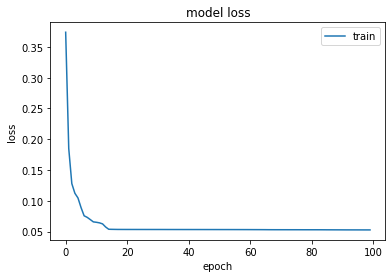

In [14]:

pyplot.plot(train_history.history['loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper right');
pyplot.show()

# save or load model

In [14]:
#bae_model.save('./myModels/unsw_normal')
# Save the weights
BDL_model.save_weights('./cic2017_checkpoints/'+savename)

In [ ]:
#reconstructed_model = tfk.models.load_model("./myModels/unsw_normal_")

BDL_model = BAE_AD(orig_dim=original_dim)
#savename='cic2017-1-vi-input-mae'  #  None # to replace the file name
## Restore the weights
BDL_model.load_weights('./cic2017_checkpoints/'+savename)  #, by_name=True)  #when using for transforming
#savename='cic2017-1-vi-input-mae'  
## Evaluate the model
#loss, acc =bae_model.evaluate(normal_train_x)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# function set

In [15]:
def get_error_term(v1,v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1-v2)**2,axis=1))
    else:        #return MAE
        return np.mean(abs(v1-v2),axis=1)

In [17]:
''' 
return RP(reconstruction probabilities), p(x|x`),p(x|mu,sigma**2)
 X: inputs
 mu,sigma from the outputs, from the last hidden layer of decoder? ,,,,or as means of each mu,sigma of hidden layers of decoder.
 RP could be used in training phase or testing phase.
'''

# only for multivariate Gaussian including MultivariateNoramlDiag() and MultivariateNormalTril()

#from scipy.stats import multivariate_normal
def RP_multivariate(x_orig,mu_post, sigma_post, L=1):
    '''
    args: 
    mu_post, sigma_post: come from the final decoder layer of test model or train model.
    x_orig: the inputs of test model or train model.
    L: the number of latent layers
    return:
    the probabilities of the distribution of x_orig on (mu_post,sigma_post) using multivariate Gaussian distribution.
    Another alternative method is original multivariate distribution model or mixture.
    '''
    #sigma_post2=tf.clip_by_value(sigma_post,1e-10, tf.reduce_max(sigma_post))
    ##sigma_post2==tf.math.exp(sigma_post2)
   
    recon_dist =tfp.distributions.MultivariateNormalDiag(mu_post,sigma_post)  # Multivariate Gaussian
    
    #scale=tf.matmul(sigma_post,sigma_post,transpose_a=True)  # Multivariate Gaussian full covariance 
    ##scale = tf.linalg.cholesky(sigma_post2)
    #recon_dist=tfd.MultivariateNormalTriL(mu_post,scale)
    reconstructed_prob=recon_dist.log_prob(x_orig)
    
    # scale data
    t = MinMaxScaler()
    reconstructed_prob=tf.reshape(reconstructed_prob,[-1,1])
    t.fit(reconstructed_prob)
    reconstructed_prob = t.transform(reconstructed_prob)
      
    return reconstructed_prob

def RP_normal_outp(x_orig,x_recons,L=1):
    '''    only for Normal distribution'''
    mu=tf.math.reduce_mean (x_recons,axis=1,keepdims=True)
    sigma=tf.clip_by_value( tf.math.reduce_std(x_recons, axis=1,keepdims=True), 1e-10, tf.reduce_max(x_recons))
    recon_dist =tfp.distributions.Normal(mu,sigma) 
    
    p=recon_dist.prob(x_orig)
    p1=tf.math.reduce_mean(p,axis=-1)  
    return p1

def RP_normal(x_orig,mu,sigma,L=1):
    '''     only for Normal distribution'''
    recon_dist =tfp.distributions.Normal(mu,sigma) 
    
    p=recon_dist.prob(x_orig)
    p1=tf.math.reduce_mean(p,axis=-1)  
    return p1

In [16]:
def metric3UQ(fileforname):
    pd_reader=pd.read_csv('../../venv/MyBayesian/pplots/BDL'+fileforname+'+allmetrics.csv' )  #,skiprows=251)   
    save_path = "pplots/BDL"+fileforname+'+allmetricsSum'+".csv"

    #print(pd_reader.head())
    modelname='BDL'
    model_dict_total={}
    model_dict_alea={}
    model_dict_epis={}
    model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
    model_dict_alea["metricname"]=pd_reader.iloc[17,1:19]
    model_dict_epis["metricname"]=pd_reader.iloc[17,1:19]
    for each in range(1,len( attack_types)):
        fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
        fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')

        for i in range(1,len(pd_reader) ,18*3):
            if '+' in pd_reader.iloc[i,0] :

                if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                    legendd=pd_reader.iloc[i,0].split('+')[0]

                    if legendd in model_dict_total.keys():
                        model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                        model_dict_alea[legendd]=model_dict_alea[legendd]+pd_reader.iloc[i+17+18,1:19].astype(np.float16)
                        model_dict_epis[legendd]=model_dict_epis[legendd]+pd_reader.iloc[i+17+18+18,1:19].astype(np.float16)
                    else: 
                        model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16)    
                        model_dict_alea[legendd]=pd_reader.iloc[i+17+18,1:19].astype(np.float16) 
                        model_dict_epis[legendd]=pd_reader.iloc[i+17+18*2,1:19].astype(np.float16) 

                    #fig_title=pd_reader.iloc[i,0]
                    try:
                        xx=pd_reader.iloc[i+2,1:].astype(int)
                    except:
                        print(i)

                    # total uncertainty
                    y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                    y_uncer2=pd_reader.iloc[i+15+18,1:].astype(np.float16)  # alea
                    y_uncer3=pd_reader.iloc[i+15+18*2,1:].astype(np.float16)   #epis
                    #plot_title=pd_reader.iloc[i+2,0]            
                    #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # auc
                    y_values=pd_reader.iloc[i+9,1:].astype(np.float16)   # accu_total
                    y_values2=pd_reader.iloc[i+9+18,1:].astype(np.float16)   # accu_alea
                    y_values3=pd_reader.iloc[i+9+18*2,1:].astype(np.float16)   # accu_epis

                    # ACCU_total
                    ax1.plot(xx,y_values,label=legendd)                
                    ax1.fill_between(xx,y_values-np.absolute(y_uncer),y_values+np.absolute(y_uncer),alpha=0.3,facecolor='grey')
                    ax1.set(ylabel='Percent')              
                    # ACCU_alea
                    ax2.plot(xx, y_values2) # , 'tab:green')        
                    ax2.fill_between(xx,y_values2-np.absolute(y_uncer2),y_values2+np.absolute(y_uncer2),alpha=0.3,facecolor='grey')        
                    # ACCU_epis
                    ax3.plot(xx, y_values3 ) #, 'tab:orange') 
                    ax3.fill_between(xx,y_values3-np.absolute(y_uncer3),y_values3+np.absolute(y_uncer3),alpha=0.3,facecolor='grey')         

                    # AUC
                    ax4.plot(xx, pd_reader.iloc[i+3,1:].astype(np.float16) ) # , 'tab:red') 

                    #ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test

                    if each==1:
                        ax1.set_title('Total')
                        ax2.set_title('Aleatoric') 
                        ax3.set_title('epistemic')
                        ax4.set_title('AUC') 
                    if each==len(attack_types)-1:
                        ax1.set(xlabel='Rejection')
                        ax2.set(xlabel='Rejection')
                        ax3.set(xlabel='Rejection')
                        ax4.set(xlabel='Rejection')
                    '''
                    # F1
                    ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                    ax6.set_title(pd_reader.iloc[i+12,0])
                    #ax6.set(xlabel='Rejection')
                     #GSS
                    ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                    ax2.set_title(pd_reader.iloc[i+4,0])
                    #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                    '''


        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))

        for ax in fig.get_axes():
            ax.label_outer()
            ax.set_xlim(0,60)
            ax.set_ylim(0,1)
        '''    
        total_auc=(total_auc+best_auc  ) /2
        tw_auc=(tw_auc+w_auc)/2
        tw_accu=(tw_accu+w_accu)/2

        nowtime=datetime.datetime.now()
        nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)  

        pyplot.savefig('plots/'+savename+'+'+"alluncer.png")
        '''
        pyplot.show()

    for aproblegend in model_dict_total.keys():
        if aproblegend != 'metricname':
            model_dict_total[aproblegend]=model_dict_total[aproblegend]/(len(attack_types)-1)
            model_dict_alea[aproblegend]=model_dict_alea[aproblegend]/(len(attack_types)-1)
            model_dict_epis[aproblegend]=model_dict_epis[aproblegend]/(len(attack_types)-1)
    '''    
    model_dict_total["Gaussian1"]=model_dict_total["Gaussian1"]/(len(attack_types)-1)
    model_dict_alea["Gaussian1"]=model_dict_alea["Gaussian1"]/(len(attack_types)-1)
    model_dict_epis["Gaussian1"]=model_dict_epis["Gaussian1"]/(len(attack_types)-1)
    model_dict_total["GaussianCustom"]=model_dict_total["GaussianCustom"]/(len(attack_types)-1)
    model_dict_alea["GaussianCustom"]=model_dict_alea["GaussianCustom"]/(len(attack_types)-1)
    model_dict_epis["GaussianCustom"]=model_dict_epis["GaussianCustom"]/(len(attack_types)-1)
    model_dict_total["ECODLinear"]=model_dict_total["ECODLinear"]/(len(attack_types)-1)
    model_dict_alea["ECODLinear"]=model_dict_alea["ECODLinear"]/(len(attack_types)-1)
    model_dict_epis["ECODLinear"]=model_dict_epis["ECODLinear"]/(len(attack_types)-1)    
    '''         
    save_data=pd.DataFrame(model_dict_total)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
    save_data=pd.DataFrame(model_dict_alea)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
    save_data=pd.DataFrame(model_dict_epis)
    save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

In [15]:

from sklearn.decomposition import PCA

 # PCA 
 # latent:option1
 #examine the latent space generated by the encoder
def pca_latent(attackname,data_x):
    pca = PCA(n_components=2)
    X_transform = pca.fit_transform(data_x)

    # latent:option2
    pyplot.figure(figsize=(12, 10))
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
    pyplot.title(attackname)
    pyplot.grid()
    pyplot.show()

'''
    # option:1
    pyplot.figure(figsize=(12, 10))
    #plot The image below shows a scatter plot of the latent space generated by the encoder (after dim reduction to 2 dims). 
    #The color of each point reflects its associated reconstruction error term (in the mae_vector). 
    #A darker dot implies a larger error term. 
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
    pyplot.grid()
    pyplot.title(attackname)
    #save the plot
    f=pyplot.gcf()
    f.savefig('aa.pdf')
    #f.savefig(r'D:\{}.pdf'.format(ind),dpi=100)
    f.clear()
    # show the plot
    pyplot.show()
'''
'''
    #  # latent:option3
    # compare the above to the ground-truth plot below which actually shows the true labels of the data. 
    pyplot.figure(figsize=(12, 10))
    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
    pyplot.title(attackname)
    pyplot.grid()
    pyplot.show()
    '''

'\n    #  # latent:option3\n    # compare the above to the ground-truth plot below which actually shows the true labels of the data. \n    pyplot.figure(figsize=(12, 10))\n    sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)\n    pyplot.title(attackname)\n    pyplot.grid()\n    pyplot.show()\n    '

# testing+ more dist

In [ ]:
'''
all epistemic uncertainty equals zeros in AE, VAE.
'''
alluncertainty_dict={}     # record all UQ under multiple distributions on anoamly score.
all_AS_AP_dict={}    # record all anoamly scores and anoamly probabilities in T times repeats. the defalut is mae reconstruction error.
all_AS_AP_2_dict={}   # record the second anoamly score through another reconstruction error measure method. e.g. rmse
all_test_y_2_dict={}
newname=savename+'-mse' #+'11'

T=1      # the times of prediction, i.e. the number of parameters samples.
distribution_types=['G1','G2', 'Triang']       #   'GC', 'Uniform','Gamma', 'Poisson','T','ECDF','ECOD'
'''
G1: standard Gaussian, i.e. mean=0,std=1
G2: customized Gaussian using CDF()
GC: customized Gaussian using erf()
'''
#start to timeing
start=time.time()
for attackindex in range(1,16):     #16, the 15th including all attack types  
    cont=np.load(dicnpy+"test-"+str(attackindex)+".npy",allow_pickle=True)
    print(f'the {attackindex}th attack data with name of {attack_types[attackindex]}')
    test_x,test_y=column_split_bina(cont)
    test_x = np.nan_to_num(test_x)
                
    if type(test_x)==False:
        print('test_x is False!')
    for i in range(0,len(test_y)):
        if test_y[i]!=0:
            test_y[i]=1
    
    all_test_y_2_dict[attackindex]=test_y
    # scale data
    t = MinMaxScaler()
    t.fit(test_x)
    test_x2 = t.transform(test_x)

    mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores

    for i in range(0,T):  
        outp=BDL_model.predict(test_x2)
        if len(outp)==3:  # for Tensorflow models
            test_mu,test_std,test_recon=outp[0],outp[1],outp[2]
        elif len(outp)==1 or len(outp)>20:
            test_recon=outp
            test_mu=np.mean(test_recon)
            test_std=np.var(test_recon)
        else:  # for BangXY models
            test_recon=outp['y_pred']  # 'se','bce'
            test_mu=np.mean(test_recon)
            test_std=np.var(test_recon)            

        mae_vector = get_error_term(test_recon, test_x2, _rmse=True) 
        all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)]=mae_vector
        mean_AS=mean_AS+mae_vector
        
        mse_vector=get_error_term(test_recon, test_x2, _rmse=False) 
        all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)]=mse_vector
        
        # test 2.1------------------------standard Gaussian------------------------------------
        mae_vector_prob=copy.deepcopy(mae_vector)
        #mae_vector_prob=regular_log(mae_vector)   ######################
        #mae_vector_prob=regular_linear(mae_vector) 

        # 1.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
        #mae_vector_prob=cdf_gaussian_1( mae_vector_prob) 
        
        mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     
        #mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
        #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
        #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G1']=mae_vector_prob
        mean_G1=mean_G1+mae_vector_prob

         #-------------------Customized Gaussian using CDF-----------------------------------------
        mae_vector_prob=copy.deepcopy(mae_vector)
        #mae_vector_prob=regular_log(mae_vector)   ######################
        #mae_vector_prob=regular_linear(mae_vector) 

        # 2.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
        #mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     
        mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
        #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
        #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G2']=mae_vector_prob 
        mean_G2=mean_G2+mae_vector_prob

        '''
        ##----------------------------Customized Gaussian using erf()-----------------------------------------
        # test ,not good
        mae_vector_prob=copy.deepcopy(mae_vector)
        ##mae_vector_prob=regular_log(mae_vector) 
        mae_vector_prob=regular_linear(mae_vector) 

        # 3.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob)   ##############

        mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
        #mae_vector_prob=np.absolute(mae_vector_prob)

        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_GC']=mae_vector_prob
        mean_GC=mean_GC+mae_vector_prob
        '''
        '''
        # 4.the anomaly scores following Gamma distribution -----------------------------------------------

        mae_vector_prob=copy.deepcopy(mae_vector )  
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)             
        #mae_vector_prob=add_gamma(mae_vector_prob) 
        #mae_vector_prob=cdf_gamma( mae_vector_prob) 
            
        mae_vector_prob=normalization_gamma(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Gamma']=mae_vector_prob
        mean_Gamma=mean_Gamma+mae_vector_prob
        
        
         # 5.the anomaly scores following poisson distribution   ------------------------------ 
        mae_vector_prob=copy.deepcopy(mae_vector  )     
        #mae_vector_prob=regular_log(mae_vector)
        mae_vector_prob=regular_linear(mae_vector)         
        #mae_vector_prob=add_poisson(mae_vector_prob) 
        #mae_vector_prob=cdf_poisson( mae_vector_prob) 
        
        mae_vector_prob=normalization_poisson(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Poisson']=mae_vector_prob
        mean_Poisson=mean_Poisson+mae_vector_prob


         # 6.the anomaly scores following uniform distribution -----------------------------------    
        
        mae_vector_prob=copy.deepcopy(mae_vector) 
        #mae_vector_prob=regular_log(mae_vector)
        mae_vector_prob=regular_linear(mae_vector)               
        #mae_vector_prob=add_uniform(mae_vector_prob)  
        #mae_vector_prob=cdf_uniform( mae_vector_prob)               
        mae_vector_prob=normalization_uniform(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Uniform']=mae_vector_prob
        mean_Uniform=mean_Uniform+mae_vector_prob
        '''
         # 7.the anomaly scores following triang distribution   ----------------------------------    

        mae_vector_prob=copy.deepcopy(mae_vector )   
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)            
        #mae_vector_prob=add_triang(mae_vector_prob)    
        #mae_vector_prob=cdf_triang( mae_vector_prob)             
        mae_vector_prob=normalization_triang(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Triang']=mae_vector_prob
        mean_Triang=mean_Triang+mae_vector_prob

        '''
         # 8.the anomaly scores following students T distribution   ----------------------------------    

        mae_vector_prob=copy.deepcopy(mae_vector)
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)                
        #mae_vector_prob=add_t(mae_vector_prob)  
        #mae_vector_prob=cdf_t( mae_vector_prob)               
        mae_vector_prob=normalization_t(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_T']=mae_vector_prob
        mean_T=mean_T+mae_vector_prob
        
        # test 9 -----------------------pure CDF-------------------------------------
        # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
        #3. alternative: pure cdf()   
        #mae_vector_prob=stats.norm.cdf(mae_vector)  
        
        #-------------------------------ECDF-----------------------------------------
        # 3.1 ecdf       
        #mae_vector_prob=regular_log(mae_vector)
        mae_vector_prob=regular_linear(mae_vector)
        #mae_vector_prob=cdf_ECDF( mae_vector_prob) 
        mae_vector_prob=normalization_ECDF(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECDF']=mae_vector_prob
        mean_ECDF=mean_ECDF+mae_vector_prob
        ''''''
        # test 10---------------------ECOD-------------------------------------------    
        mae_vector_prob=copy.deepcopy(mae_vector)
        #mae_vector_prob=regular_log(mae_vector)       ###################### 
        #mae_vector_prob=regular_linear(mae_vector)
        mae_vector_prob=normalization_ECOD( mae_vector_prob)   # 
        #mae_vector_prob=np.absolute(mae_vector_prob)
        
         # scale data
        t = MinMaxScaler()
        temp=tf.reshape(mae_vector_prob,[-1,1])
        t.fit(temp)
        temp = t.transform(temp)                
        mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()

        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECOD']=mae_vector_prob
        mean_ECOD=mean_ECOD+mae_vector_prob
        '''
    mean_AP={}
    mean_AP['AS']=mean_AS/T
    mean_AP['G1']=mean_G1/T
    mean_AP['G2']=mean_G2/T
    mean_AP['GC']=mean_GC/T
    mean_AP['Gamma']=mean_Gamma/T
    mean_AP['Poisson']=mean_Poisson/T
    mean_AP['Uniform']=mean_Uniform/T
    mean_AP['Triang']=mean_Triang/T
    mean_AP['T']=mean_T/T
    mean_AP['ECDF']=mean_ECDF/T
    mean_AP['ECOD']=mean_ECOD/T
    mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores

    mean_alea={}
    mean_epis={}
    for dist in distribution_types:
        mean_alea[dist]=0
        mean_epis[dist]=0

    mean_AS_alea=0
    mean_AS_epis=0

    for i in range(0,T):  
        mean_AS_alea+= all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)]*(1-all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
        #mean_AS_epis +=(all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)] - mean_AP['AS'])**2  

        for dist in distribution_types:
            if all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                mean_alea[dist] += np.mean(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                #mean_epis[dist] += (np.mean(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                #epi=np.absolute(epi)    # sometimes epi<0 ?
            else:
                mean_alea[dist] += all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                #mean_epis[dist] +=(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                #epi=np.absolute(epi)   
    mean_AS_alea=mean_AS_alea/T
    #mean_AS_alea=np.clip(mean_AS_alea,0, np.max(mean_AS_alea))  
    mean_AS_epis=np.zeros_like( mean_AS_alea)
    #mean_AS_epis=np.clip(mean_AS_epis,0, np.max(mean_AS_epis))  
    alluncertainty_dict[attack_types[attackindex]+'_AS_alea']=mean_AS_alea
    alluncertainty_dict[attack_types[attackindex]+'_AS_epis']=mean_AS_epis
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea+mean_AS_epis, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_epis, y_true=test_y,plot=False) 

    for dist in distribution_types:
        mean_alea[dist]=mean_alea[dist]/T
        #mean_alea[dist]=np.clip(mean_alea[dist],0, np.max(mean_alea[dist]))  
        mean_epis[dist]=np.zeros_like(mean_alea[dist])      
        #mean_epis[dist]=np.clip(mean_epis[dist],0, np.max(mean_epis[dist]))                 
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_alea']=mean_alea[dist] 
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_epis']=mean_epis[dist]

        #plot_UQ_density(mean_alea[dist],mean_epis[dist], 80,'BDL'+savename+'_'+dist+'_'+attack_types[attackindex])

        #uncer_total=getsortedindex(mean_alea[dist],mean_epis[dist] )
        uncer_total=mean_alea[dist] +mean_epis[dist]
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=uncer_total, y_true=test_y,plot=False)  #uncer_total
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=mean_alea[dist], y_true=test_y,plot=False) 
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                    unc_total=mean_epis[dist], y_true=test_y,plot=False) 

    #break
    
end=time.time()                 
runTime=pd.DataFrame({'ModelName':['BDL'+savename],'Phase':['test'],'M':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)],'batch':[0],'epoch':[0]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)

del result_dic,   mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD, mean_AS, mean_AP
del mae_vector, mse_vector, mae_vector_prob,uncer_total,mean_alea,mean_epis,mean_AS_alea,mean_AS_epis

the 1th attack data with name of FTP-Patator


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/MyBayesian/

the 2th attack data with name of SSH-Patator


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

the 3th attack data with name of DoS GoldenEye


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 4th attack data with name of DoS Hulk


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

the 5th attack data with name of DoS Slowhttptest


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

the 6th attack data with name of DoS slowloris


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

the 7th attack data with name of Heartbleed


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 8th attack data with name of Web Attack � Brute Force


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/

the 9th attack data with name of Web Attack � XSS


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/

the 10th attack data with name of Web Attack � Sql Injection


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/

the 11th attack data with name of Infiltration


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/MyBayesian/

the 12th attack data with name of Bot


/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

the 13th attack data with name of DDoS


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

the 14th attack data with name of PortScan


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

the 15th attack data with name of AllAttack


/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

In [ ]:
# for mae anomaly score
uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"   # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
save_uncer = pd.DataFrame.from_dict(alluncertainty_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del uncer_save_path,ASAP_save_path,save_uncer,save_ASAP, alluncertainty_dict,all_AS_AP_dict


In [ ]:


#newname='cic2017-1-vi-last-model-mae-mae11'
#newname=savename  +'-mse'
print(newname)
metric3UQ(newname)

In [18]:

alluncertainty_dict={}     # record all UQ under multiple distributions on anoamly score.
newname=savename+'-mae'
#T=3
distribution_types=['G1','G2' ,'Triang']       # 'GC'， 'Gamma',  'Uniform','T', 'Poisson','ECDF','ECOD'

#start to timeing
start=time.time()
for attackindex in range(1,16):     #16, the 15th including all attack types  
    mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores

    for i in range(0,T):  
        mae_vector = all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)]
        mean_AS=mean_AS+mae_vector
                
        # test 2.1------------------------standard Gaussian------------------------------------
        #mae_vector_prob=regular_log(mae_vector)   ######################
        #mae_vector_prob=regular_linear(mae_vector) 
        mae_vector_prob=copy.deepcopy(mae_vector)

        # 1.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
        #mae_vector_prob=cdf_gaussian_1( mae_vector_prob) 
        
        mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     
        #mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
        #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
        #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))

        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G1']=mae_vector_prob
        mean_G1=mean_G1+mae_vector_prob

         #-------------------Customized Gaussian using CDF-----------------------------------------
        #mae_vector_prob=regular_log(mae_vector)   ######################
        #mae_vector_prob=regular_linear(mae_vector) 
        mae_vector_prob=copy.deepcopy(mae_vector)

        # 2.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
        #mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     
        mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
        #mae_vector_prob=normalization_gaussian_3(mae_vector_prob)
        #mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G2']=mae_vector_prob 
        mean_G2=mean_G2+mae_vector_prob

        '''
        ##----------------------------Customized Gaussian using erf()-----------------------------------------
        # test ,not good
        ##mae_vector_prob=regular_log(mae_vector)
        mae_vector_prob=regular_linear(mae_vector)  
        #mae_vector_prob=copy.deepcopy(mae_vector)

        # 3.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob)   ##############

        mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
        #mae_vector_prob=np.absolute(mae_vector_prob)

        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_GC']=mae_vector_prob
        mean_GC=mean_GC+mae_vector_prob
        '''
        '''
        # 4.the anomaly scores following Gamma distribution -----------------------------------------------

        #mae_vector_prob=regular_log(mae_vector)
        mae_vector_prob=regular_linear(mae_vector)
        #mae_vector_prob=copy.deepcopy(mae_vector )               
        #mae_vector_prob=add_gamma(mae_vector_prob) 
        #mae_vector_prob=cdf_gamma( mae_vector_prob) 
            
        mae_vector_prob=normalization_gamma(mae_vector_prob)
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Gamma']=mae_vector_prob
        mean_Gamma=mean_Gamma+mae_vector_prob
        '''
        '''
         # 5.the anomaly scores following poisson distribution   ------------------------------ 
        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)
        mae_vector_prob=copy.deepcopy(mae_vector  )              
        mae_vector_prob=add_poisson(mae_vector_prob) 
        #mae_vector_prob=cdf_poisson( mae_vector_prob) 
        
        mae_vector_prob=normalization_poisson(mae_vector_prob)
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Poisson']=mae_vector_prob
        mean_Poisson=mean_Poisson+mae_vector_prob


         # 6.the anomaly scores following uniform distribution -----------------------------------    
        
        #mae_vector_prob=regular_log(mae_vector)
        mae_vector_prob=regular_linear(mae_vector)
        #mae_vector_prob=copy.deepcopy(mae_vector)                
        #mae_vector_prob=add_uniform(mae_vector_prob)  
        #mae_vector_prob=cdf_uniform( mae_vector_prob)               
        mae_vector_prob=normalization_uniform(mae_vector_prob)
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Uniform']=mae_vector_prob
        mean_Uniform=mean_Uniform+mae_vector_prob
        '''
         # 7.the anomaly scores following Triang distribution   ----------------------------------    

        #mae_vector_prob=regular_log(mae_vector)
        #mae_vector_prob=regular_linear(mae_vector)
        mae_vector_prob=copy.deepcopy(mae_vector )               
        #mae_vector_prob=add_triang(mae_vector_prob)    
        #mae_vector_prob=cdf_triang( mae_vector_prob)             
        mae_vector_prob=normalization_triang(mae_vector_prob)
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Triang']=mae_vector_prob
        mean_Triang=mean_Triang+mae_vector_prob

        '''
         # 8.the anomaly scores following students T distribution   ----------------------------------    

        #mae_vector_prob=regular_log(mae_vector)
        mae_vector_prob=regular_linear(mae_vector)
        #mae_vector_prob=copy.deepcopy(mae_vector)                
        #mae_vector_prob=add_t(mae_vector_prob)  
        #mae_vector_prob=cdf_t( mae_vector_prob)               
        mae_vector_prob=normalization_t(mae_vector_prob)
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_T']=mae_vector_prob
        mean_T=mean_T+mae_vector_prob
        '''
        '''
        # test 9 -----------------------pure CDF-------------------------------------
        # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
        #3. alternative: pure cdf()   
        #mae_vector_prob=stats.norm.cdf(mae_vector)  
        ''''''
        #-------------------------------ECDF-----------------------------------------
        # 3.1 ecdf       
        #mae_vector_prob=regular_log(mae_vector)
        mae_vector_prob=regular_linear(mae_vector)
        #mae_vector_prob=cdf_ECDF( mae_vector_prob) 
        mae_vector_prob=normalization_ECDF(mae_vector_prob)
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECDF']=mae_vector_prob
        mean_ECDF=mean_ECDF+mae_vector_prob
        
        # test 10---------------------ECOD-------------------------------------------
        #mae_vector_prob=regular_log(mae_vector)       ###################### 
        #mae_vector_prob=regular_linear(mae_vector)    
        mae_vector_prob=copy.deepcopy(mae_vector)
        mae_vector_prob=normalization_ECOD( mae_vector_prob)   # 
        #mae_vector_prob=np.absolute(mae_vector_prob)
        
         # scale data
        t = MinMaxScaler()
        temp=tf.reshape(mae_vector_prob,[-1,1])
        t.fit(temp)
        temp = t.transform(temp)                
        mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()

        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECOD']=mae_vector_prob
        mean_ECOD=mean_ECOD+mae_vector_prob
        '''
    mean_AP={}
    mean_AP['AS']=mean_AS/T
    mean_AP['G1']=mean_G1/T
    mean_AP['G2']=mean_G2/T
    mean_AP['GC']=mean_GC/T
    mean_AP['Gamma']=mean_Gamma/T
    mean_AP['Poisson']=mean_Poisson/T
    mean_AP['Uniform']=mean_Uniform/T
    mean_AP['Triang']=mean_Triang/T
    mean_AP['T']=mean_T/T
    mean_AP['ECDF']=mean_ECDF/T
    mean_AP['ECOD']=mean_ECOD/T
    mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores

    mean_alea={}
    mean_epis={}
    for dist in distribution_types:
        mean_alea[dist]=0
        mean_epis[dist]=0

    mean_AS_alea=0
    mean_AS_epis=0

    for i in range(0,T):  
        mean_AS_alea+= all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)]*(1-all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
        #mean_AS_epis +=(all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)] - mean_AP['AS'])**2  

        for dist in distribution_types:
            if all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                mean_alea[dist] += np.mean(all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                #mean_epis[dist] += (np.mean(all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                #epi=np.absolute(epi)    # sometimes epi<0 ?
            else:
                mean_alea[dist] += all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                #mean_epis[dist] +=(all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                #epi=np.absolute(epi)   
    mean_AS_alea=mean_AS_alea/T
    mean_AS_epis=np.zeros_like( mean_AS_alea)
    alluncertainty_dict[attack_types[attackindex]+'_AS_alea']=mean_AS_alea
    alluncertainty_dict[attack_types[attackindex]+'_AS_epis']=mean_AS_epis
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea+mean_AS_epis, y_true=
all_test_y_2_dict[attackindex], plot=False) 
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea, y_true=all_test_y_2_dict[attackindex],plot=False) 
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_epis, y_true=all_test_y_2_dict[attackindex],plot=False) 

    for dist in distribution_types:
        mean_alea[dist]=mean_alea[dist]/T
        mean_epis[dist]=np.zeros_like( mean_alea[dist])                     
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_alea']=mean_alea[dist] 
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_epis']=mean_epis[dist]

        #plot_UQ_density(mean_alea[dist],mean_epis[dist], 80,'BDL'+savename+'_'+dist+'_'+attack_types[attackindex])

        uncer_total=[]
        #uncer_total=getsortedindex(mean_alea[dist],mean_epis[dist] )
        uncer_total=mean_alea[dist] +mean_epis[dist]
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=uncer_total, y_true=all_test_y_2_dict[attackindex],plot=False)  #uncer_total
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=mean_alea[dist], y_true=all_test_y_2_dict[attackindex],plot=False) 
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                    unc_total=mean_epis[dist], y_true=all_test_y_2_dict[attackindex],plot=False) 

    #break
    
end=time.time()                 
runTime=pd.DataFrame({'ModelName':['BDL'+savename],'Phase':['test'],'M':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)],'batch':[0],'epoch':[0]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)

del result_dic,   mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD, mean_AS, mean_AP
del mae_vector, mae_vector_prob,mean_alea,mean_epis,mean_AS_alea,mean_AS_epis,uncer_total

/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/MyBayesian/utils/metrics.py:265: RuntimeWarning: invalid value encountered in double_scalars
  wuncer=np.sum(weightuncer)/wf_uncer
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tengfei/venv/tensorflow/lib/python

In [19]:
# for mae anomaly score
uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"   # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
save_uncer = pd.DataFrame.from_dict(alluncertainty_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_2_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del uncer_save_path,ASAP_save_path,save_uncer,save_ASAP, alluncertainty_dict,all_AS_AP_2_dict,all_test_y_2_dict


In [ ]:
#newname=savename  +'-mse'
metric3UQ(newname)

## plot single uncertainty

In [ ]:
# under 3+1 , calculate total of each
savename='test'
#pd_reader=pd.read_csv('../../venv/MyBayesian/plots/BAE'+'allmetrics.csv' )                       
#print(pd_reader.head())

# plot comparision in different phase of each type
total_auc=0 # average of the largest AUC of each types
modelname='BAE MCdropout'
tw_auc,tw_accu=0,0
model_dict={}
model_dict["metricname"]=pd_reader.iloc[17,1:19]
for each in range(1,len( attack_types)):
    fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    best_auc=0
    w_auc=0  #average
    w_accu=0  # average
    #for i in range(0,len(pd_reader)):
    i=1
    while i<len(pd_reader):
        flag=False        
        if '+' in pd_reader.iloc[i,0] :
            if pd_reader.iloc[i,0].split('+')[1]==attack_types[each]:
                print(i)
                legendd=pd_reader.iloc[i,0].split('+')[0]
                if legendd in model_dict.keys():
                    model_dict[legendd]=model_dict[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)                    
                else: 
                    model_dict[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16) 
                    
                #fig_title=pd_reader.iloc[i,0]
                try:
                    xx=pd_reader.iloc[i+2,1:].astype(int)
                except:
                    print(i)
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)

                plot_title=pd_reader.iloc[i+2,0]            
                y_values=pd_reader.iloc[i+3,1:].astype(np.float16)
                ''' 
                if best_auc<  np.max(y_values):
                    best_auc=np.max(y_values)
                if w_auc<float(pd_reader.iloc[i+17,2]):
                    w_auc=float( pd_reader.iloc[i+17,2])
                    # print(f'the better weight_auc {w_auc}is belongs: {attack_types[each]}{legendd}')
                if w_accu<float(pd_reader.iloc[i+17,3]):
                    w_accu=float(pd_reader.iloc[i+17,3])
                    #print(f'the better weight_accu {w_accu}is belongs: {attack_types[each]}{legendd}')
                   # for remove angles
                for ind in range(1,len(y_values)):
                    if np.abs((y_values[ind-1]-y_values[ind]))>0.6:
                        yyy=y_values[:,ind-1]                        
                        xxx=xx[:,ind-1]
                        '''
                # AUC
                ax1.plot(xx,y_values,label=legendd)                
                ax1.fill_between(xx,y_values-np.absolute(y_uncer),y_values+np.absolute(y_uncer),alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU
                ax2.plot(xx, pd_reader.iloc[i+9,1:].astype(np.float16) ) # , 'tab:green')                
                # FPR
                ax3.plot(xx, pd_reader.iloc[i+7,1:].astype(np.float16) ) #, 'tab:orange')          
                
                # Macro F1
                #ax4.plot(xx, pd_reader.iloc[i+11,1:].astype(np.float16) ) # , 'tab:red')               
                
                ax4.plot(xx, pd_reader.iloc[i+5,1:].astype(np.float16) ) # , 'tab:red')   # accu2 follow AUC            
                
                if each==1:
                    ax1.set_title(plot_title)
                    ax2.set_title(pd_reader.iloc[i+8,0]) 
                    ax3.set_title(pd_reader.iloc[i+6,0])
                    ax4.set_title(pd_reader.iloc[i+4,0])   # [i+10,0]) # macro F1 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
                '''
                # F1
                ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                ax6.set_title(pd_reader.iloc[i+12,0])
                #ax6.set(xlabel='Rejection')
                 #GSS
                ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                ax2.set_title(pd_reader.iloc[i+4,0])
                #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                
                if legendd=='GaussianCustom':
                    i=i+18*3 
                    flag=True
                elif legendd=='ECODLinear':
                    i=i+18
                    flag=True
                '''                      
                i=i+18
                flag=True
        if not flag:
            i=i+1                   
   
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
    '''
    total_auc=(total_auc+best_auc  ) /2
    tw_auc=(tw_auc+w_auc)/2
    tw_accu=(tw_accu+w_accu)/2
    
    nowtime=datetime.datetime.now()
    nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)    
    pyplot.savefig('plots/'+modelname+'+'+nowtime+'+'+"allmetrics.png")
    '''
    pyplot.show()
   
for aproblegend in model_dict_total.keys():
    if aproblegend != 'metricname':
        model_dict[aproblegend]=model_dict[aproblegend]/(len(attack_types)-1)
                      
#model_dict['Gaussian1']=model_dict['Gaussian1']/(len(attack_types)-1)
#model_dict['GaussianCustom']=model_dict['GaussianCustom']/(len(attack_types)-1)
#model_dict['ECODLinear']=model_dict['ECODLinear']/(len(attack_types)-1)
         
#print(f'the AUC of this model is {total_auc}')
save_path = "plots/"+'allmetrics+'+savename+".csv"
#final_AUC={'total_AUC':total_auc, 'weight_AUC:':tw_auc,'weight_Accu:':tw_accu}
#save_data = pd.DataFrame.from_dict([final_AUC])
#save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

save_data=pd.DataFrame(model_dict)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

In [16]:
print(model_dict.keys())

dict_keys(['metricname'])


## 3+1

In [28]:
#savename='cic2017-vi-last-bce'
pd_reader=pd.read_csv('../../venv/MyBayesian/plots/BAE'+savename+'+allmetrics.csv' )  #,skiprows=251)   
#print(pd_reader.head())
modelname='BAE'
model_dict_total={}
model_dict_alea={}
model_dict_epis={}
model_dict_total["metricname"]=pd_reader.iloc[17,1:19]
model_dict_alea["metricname"]=pd_reader.iloc[17,1:19]
model_dict_epis["metricname"]=pd_reader.iloc[17,1:19]
for each in range(1,len( attack_types)):
    #fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    #fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    i=1
    #for i in range(1,len(pd_reader)):  # ,18*3):
    while i<len(pd_reader):
        flag=False
        if '+' in pd_reader.iloc[i,0] :
            
            if pd_reader.iloc[i,0].split('+')[1].split('.')[0]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]
                
                if legendd in model_dict_total.keys():
                    if legendd=='GaussianCustom':
                        model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                        model_dict_alea[legendd]=model_dict_alea[legendd]+pd_reader.iloc[i+17+18,1:19].astype(np.float16)
                        model_dict_epis[legendd]=model_dict_epis[legendd]+pd_reader.iloc[i+17+18+18,1:19].astype(np.float16)
                    elif legendd=='ECODLinear':
                        model_dict_total[legendd]=model_dict_total[legendd]+pd_reader.iloc[i+17,1:19].astype(np.float16)
                else: 
                    if legendd=='GaussianCustom':
                        model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16)    
                        model_dict_alea[legendd]=pd_reader.iloc[i+17+18,1:19].astype(np.float16) 
                        model_dict_epis[legendd]=pd_reader.iloc[i+17+18*2,1:19].astype(np.float16) 
                    elif legendd=='ECODLinear':
                        model_dict_total[legendd]=pd_reader.iloc[i+17,1:19].astype(np.float16) 
                '''    
                #fig_title=pd_reader.iloc[i,0]
                try:
                    xx=pd_reader.iloc[i+2,1:].astype(int)
                except:
                    print(i)
                    
                # total uncertainty
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                y_uncer2=pd_reader.iloc[i+15+18,1:].astype(np.float16)  # alea
                y_uncer3=pd_reader.iloc[i+15+18*2,1:].astype(np.float16)   #epis
                #plot_title=pd_reader.iloc[i+2,0]            
                #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # auc
                y_values=pd_reader.iloc[i+9,1:].astype(np.float16)   # accu_total
                y_values2=pd_reader.iloc[i+9+18,1:].astype(np.float16)   # accu_alea
                y_values3=pd_reader.iloc[i+9+18*2,1:].astype(np.float16)   # accu_epis
                
                # ACCU_total
                ax1.plot(xx,y_values,label=legendd)                
                ax1.fill_between(xx,y_values-np.absolute(y_uncer),y_values+np.absolute(y_uncer),alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU_alea
                ax2.plot(xx, y_values2) # , 'tab:green')        
                ax2.fill_between(xx,y_values2-np.absolute(y_uncer2),y_values2+np.absolute(y_uncer2),alpha=0.3,facecolor='grey')        
                # ACCU_epis
                ax3.plot(xx, y_values3 ) #, 'tab:orange') 
                ax3.fill_between(xx,y_values3-np.absolute(y_uncer3),y_values3+np.absolute(y_uncer3),alpha=0.3,facecolor='grey')         
                
                # AUC
                ax4.plot(xx, pd_reader.iloc[i+3,1:].astype(np.float16) ) # , 'tab:red') 
                
                #ax4.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #GSS for test
                
                if each==1:
                    ax1.set_title('Total')
                    ax2.set_title('Aleatoric') 
                    ax3.set_title('epistemic')
                    ax4.set_title('AUC') 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
                    '''
                '''
                # F1
                ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                ax6.set_title(pd_reader.iloc[i+12,0])
                #ax6.set(xlabel='Rejection')
                 #GSS
                ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                ax2.set_title(pd_reader.iloc[i+4,0])
                #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                '''
                if legendd=='GaussianCustom':
                    i=i+18*3 
                    flag=True
                elif legendd=='ECODLinear':
                    i=i+18
                    flag=True
                
        if not flag:
            i=i+1
    '''
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
        '''
    '''    
    total_auc=(total_auc+best_auc  ) /2
    tw_auc=(tw_auc+w_auc)/2
    tw_accu=(tw_accu+w_accu)/2
    
    nowtime=datetime.datetime.now()
    nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)  
    
    pyplot.savefig('plots/'+savename+'+'+"alluncer.png")
    '''
    #pyplot.show()
    
model_dict_total["GaussianCustom"]=model_dict_total["GaussianCustom"]/(len(attack_types)-1)
model_dict_alea["GaussianCustom"]=model_dict_alea["GaussianCustom"]/(len(attack_types)-1)
model_dict_epis["GaussianCustom"]=model_dict_epis["GaussianCustom"]/(len(attack_types)-1)
model_dict_total["ECODLinear"]=model_dict_total["ECODLinear"]/(len(attack_types)-1)
#model_dict_alea["ECODLinear"]=model_dict_alea["ECODLinear"]/(len(attack_types)-1)
#model_dict_epis["ECODLinear"]=model_dict_epis["ECODLinear"]/(len(attack_types)-1)

save_path = "plots/BAE"+savename+'+allmetricsSum'+".csv"

save_data=pd.DataFrame(model_dict_total)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
save_data=pd.DataFrame(model_dict_alea)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)
save_data=pd.DataFrame(model_dict_epis)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

In [20]:
print(savename)

cic2017-4-drop-latent-Tril-he-mae


#  RP

In [ ]:
## RP(mean, sigma) --> anomaly probability
## RP(recons) --> anomaly probability
alluncertainty_dict={}     # record all UQ under multiple distributions on anoamly score.
all_AS_AP_dict={}    # record all anoamly scores and anoamly probabilities in T times repeats.
all_AS_AP_2_dict={}
all_test_y_2_dict={}
newname=savename+'-rpNorm'

uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"  # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path

T= M      # the times of prediction, i.e. the number of parameters samples.
distribution_types=['G1','G2', 'Poisson','Triang','ECDF','ECOD']       #  'GC','Gamma','Uniform','T',
'''
G1: standard Gaussian, i.e. mean=0,std=1
G2: customized Gaussian using CDF()
GC: customized Gaussian using erf()
'''
#start to timeing
start=time.time()
for attackindex in range(1,16):     #16, the 15th including all attack types  
    cont=np.load(dicnpy+"test-"+str(attackindex)+".npy",allow_pickle=True)
    print(f'the {attackindex}th attack data with name of {attack_types[attackindex]}')
    test_x,test_y=column_split_bina(cont)
    test_x = np.nan_to_num(test_x)
                
    if type(test_x)==False:
        print('test_x is False!')
    for i in range(0,len(test_y)):
        if test_y[i]!=0:
            test_y[i]=1

    all_test_y_2_dict[attack_types[attackindex]]=test_y
    
    # scale data
    t = MinMaxScaler()
    t.fit(test_x)
    test_x2 = t.transform(test_x)

    mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores
    #mean_recon_std=0
    #mean_recon_mu=0
   # all_recon_mu=[]
#***********************************************************RP for VAE, BAE last**************************************
    #test_recon =test_recon_mu+test_recon_std*tf.random.stateless_normal(shape=(original_dim,))#0.1 # when x~(mu,std)
    #test_recon_mu, test_recon_std, test_recon=bae_model.predict(test_x2)                
    #test_recon_mu, test_recon_std, test_recon, uq_alea, uq_epit=predict_UQ(BDL_model,test_x2, 3,uqname='Kwon') #  'Kendall') #  repeat times
    for i in range(0,T):
        # BDL_model_test = BAE_AD(orig_dim=original_dim)
        # oldsavename=savegroup+str(i)
        # ## Restore the weights
        # BDL_model_test.load_weights('./unsw_checkpoints/'+oldsavename)  #, by_name=True)  #when using for transforming
        # savename=oldsavename

        outp=BDL_model.predict(test_x2)
        if len(outp)==3:  # for Tensorflow models
            test_recon_mu,test_recon_std,test_recon=outp[0],outp[1],outp[2]
        elif len(outp)==1 or len(outp)>20:
            test_recon=outp
            test_recon_mu=np.mean(test_recon)
            test_recon_std=np.var(test_recon)
        else:  # for BangXY models
            test_recon=outp['y_pred']  # 'se','bce'
            test_recon_mu=np.mean(test_recon)
            test_recon_std=np.var(test_recon)    

        # test 7  option1:RP following Normal
        rp_vector=RP_normal(test_x2,test_recon_mu, test_recon_std) 
        rp_vector=rp_vector.numpy()
        rp_vector = np.nan_to_num(rp_vector)
        rp_vector[np.where(rp_vector==np.inf)]=1                    
        rp_vector[np.where( rp_vector==-np.inf)]=0
        #rp_vector=np.clip(rp_vector,0, np.max(rp_vector))
        rp_vector=1-rp_vector

        # test 7.1  option2: RP following Multivariate Gaussian 
        rp_2_vector=RP_multivariate(test_x2,test_recon_mu, test_recon_std) 
        rp_2_vector=rp_2_vector.flatten()     
        rp_2_vector = np.nan_to_num(rp_2_vector)  
        rp_2_vector[np.where(rp_vrp_2_vectorector==np.inf)]=1                    
        rp_2_vector[np.where( rp_2_vector==-np.inf)]=0      
        #rp_2_vector=np.clip(rp_2_vector,0, np.max(rp_2_vector))
        rp_2_vector=1-rp_2_vector
        all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)]=rp_2_vector
        #### simple
        # 2.MVN  
        # test_recon=tfp.distributions.MultivariateNormalDiag(test_mu,test_std).sample()   #concerned Diag deviation; but deprecated; same value to log_prob()
        # 3. MVN Tril
        # scale=tf.matmul(test_recon_std,test_recon_std,transpose_a=True)  # Multivariate Gaussian full covariance 
        # test_recon=tfd.MultivariateNormalTriL(test_recon_mu,scale)   .sample()
        # test_recon =tfp.distributions.Normal(test_recon_mu,test_recon_std).sample()
        
        all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)]=rp_vector
        mean_AS=mean_AS+rp_vector
        #mean_recon_mu=mean_recon_mu+test_recon_mu   #  for Kendall's UQ
        #mean_recon_std=mean_recon_std+test_recon_std
        #all_recon_mu[i]=test_recon_mu
        
        # test 2.1------------------------standard Gaussian------------------------------------
        mae_vector_prob=copy.deepcopy(rp_vector)
        #mae_vector_prob=regular_log(mae_vector_prob)   ######################
        #mae_vector_prob=regular_linear(mae_vector_prob) 

        # 1.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
        #mae_vector_prob=cdf_gaussian_1( mae_vector_prob) 

        mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     

        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G1']=mae_vector_prob
        mean_G1=mean_G1+mae_vector_prob

         #-------------------Customized Gaussian using CDF-----------------------------------------
        mae_vector_prob=copy.deepcopy(rp_vector)
        #mae_vector_prob=regular_log(mae_vector_prob)   ######################
        #mae_vector_prob=regular_linear(mae_vector_prob) 

        # 2.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob) ###########     
        mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G2']=mae_vector_prob 
        mean_G2=mean_G2+mae_vector_prob

        '''
        ##----------------------------Customized Gaussian using erf()-----------------------------------------
        # test ,not good
        ##mae_vector_prob=regular_log(rp_vector)
        mae_vector_prob=regular_linear(rp_vector)  
        #mae_vector_prob=copy.deepcopy(rp_vector)

        # 3.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob)   ##############

        mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
        #mae_vector_prob=np.absolute(mae_vector_prob)

        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_GC']=mae_vector_prob
        mean_GC=mean_GC+mae_vector_prob

''''''
        # 4.the anomaly scores following Gamma distribution -----------------------------------------------

        mae_vector_prob=copy.deepcopy(rp_vector )  
        #mae_vector_prob=regular_log(mae_vector_prob)
        #mae_vector_prob=regular_linear(mae_vector_prob)             
        #mae_vector_prob=add_gamma(mae_vector_prob)   
        #mae_vector_prob=cdf_gamma( mae_vector_prob) 

        mae_vector_prob=normalization_gamma(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Gamma']=mae_vector_prob
        mean_Gamma=mean_Gamma+mae_vector_prob
        
'''
         # 5.the anomaly scores following poisson distribution   ------------------------------ 
        mae_vector_prob=copy.deepcopy(rp_vector  )  
        #mae_vector_prob=regular_log(mae_vector_prob)
        mae_vector_prob=regular_linear(mae_vector_prob)            
        #mae_vector_prob=add_poisson(mae_vector_prob)   
        #mae_vector_prob=cdf_poisson( mae_vector_prob) 

        mae_vector_prob=normalization_poisson(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Poisson']=mae_vector_prob
        mean_Poisson=mean_Poisson+mae_vector_prob
        '''

         # 6.the anomaly scores following uniform distribution -----------------------------------    

        #mae_vector_prob=copy.deepcopy(rp_vector)  
        #mae_vector_prob=regular_log(mae_vector_prob)
        mae_vector_prob=regular_linear(mae_vector_prob)              
        #mae_vector_prob=add_uniform(mae_vector_prob)     
        #mae_vector_prob=cdf_uniform( mae_vector_prob) 

        mae_vector_prob=normalization_uniform(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Uniform']=mae_vector_prob
        mean_Uniform=mean_Uniform+mae_vector_prob
        '''
         # 7.the anomaly scores following Triang distribution   ----------------------------------    

        mae_vector_prob=copy.deepcopy(rp_vector ) 
        #mae_vector_prob=regular_log(mae_vector_prob)
        #mae_vector_prob=regular_linear(mae_vector_prob)              
        #mae_vector_prob=add_triang(mae_vector_prob)     
        #mae_vector_prob=cdf_triang( mae_vector_prob) 

        mae_vector_prob=normalization_triang(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Triang']=mae_vector_prob
        mean_Triang=mean_Triang+mae_vector_prob

        '''
         # 8.the anomaly scores following studentst distribution   ----------------------------------    

        #mae_vector_prob=copy.deepcopy(rp_vector) 
        #mae_vector_prob=regular_log(mae_vector_prob)
        mae_vector_prob=regular_linear(mae_vector_prob)               
        #mae_vector_prob=add_t(mae_vector_prob) 
        #mae_vector_prob=cdf_t( mae_vector_prob) 

        mae_vector_prob=normalization_t(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_T']=mae_vector_prob
        mean_T=mean_T+mae_vector_prob
        '''
        # test 9 -----------------------pure CDF-------------------------------------
        # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
        #3. alternative: pure cdf()   
        #mae_vector_prob=stats.norm.cdf(rp_vector)  
        #-------------------------------ECDF-----------------------------------------
        # 3.1 ecdf       
        mae_vector_prob=copy.deepcopy(rp_vector)
        #mae_vector_prob=regular_log(mae_vector_prob)
        mae_vector_prob=regular_linear(mae_vector_prob)
        mae_vector_prob=normalization_ECDF(mae_vector_prob)
        #mae_vector_prob=cdf_ECDF( mae_vector_prob) 

        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECDF']=mae_vector_prob
        mean_ECDF=mean_ECDF+mae_vector_prob

        # test 10---------------------ECOD-------------------------------------------
        mae_vector_prob=copy.deepcopy(rp_vector)
        #mae_vector_prob=regular_log(mae_vector_prob)       ###################### 
        #mae_vector_prob=regular_linear(rp_vector)    
        mae_vector_prob=normalization_ECOD( mae_vector_prob)   # 
        #mae_vector_prob=np.absolute(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
         # scale data
        t = MinMaxScaler()
        temp=tf.reshape(mae_vector_prob,[-1,1])
        t.fit(temp)
        temp = t.transform(temp)                
        mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()

        all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECOD']=mae_vector_prob
        mean_ECOD=mean_ECOD+mae_vector_prob

    mean_AP={}
    mean_AP['AS']=mean_AS/T
    #mean_AP['std']=mean_recon_std/T
   # mean_AP['mu']=mean_recon_mu/T
    mean_AP['G1']=mean_G1/T
    mean_AP['G2']=mean_G2/T
    mean_AP['GC']=mean_GC/T
    mean_AP['Gamma']=mean_Gamma/T
    mean_AP['Poisson']=mean_Poisson/T
    mean_AP['Uniform']=mean_Uniform/T
    mean_AP['Triang']=mean_Triang/T
    mean_AP['T']=mean_T/T
    mean_AP['ECDF']=mean_ECDF/T
    mean_AP['ECOD']=mean_ECOD/T
    mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores

    mean_alea={}
    mean_epis={}
    for dist in distribution_types:
        mean_alea[dist]=0
        mean_epis[dist]=0

    mean_AS_alea=0
    mean_AS_epis=0

    for i in range(0,T):  
        mean_AS_alea+= all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)]*(1-all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
        mean_AS_epis +=(all_AS_AP_dict[attack_types[attackindex]+'_AS_'+str(i)] - mean_AP['AS'])**2  
        
        # mean_AS_alea+=( mean_AP['std'])**2   #  recon_mu and recon_std has 77 features, different shape
        # mean_AS_epis +=(all_recon_mu[i]- mean_AP['mu'])**2  

        for dist in distribution_types:
            if all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                mean_alea[dist] += np.mean(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                mean_epis[dist] += (np.mean(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                #epi=np.absolute(epi)    # sometimes epi<0 ?
            else:
                mean_alea[dist] += all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                mean_epis[dist] +=(all_AS_AP_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                #epi=np.absolute(epi)   
    mean_AS_alea=mean_AS_alea/T
    #mean_AS_alea=np.clip(mean_AS_alea,0, np.max(mean_AS_alea))
    mean_AS_epis=mean_AS_epis/T
    #mean_AS_epis=np.clip(mean_AS_epis,0, np.max(mean_AS_epis))
    alluncertainty_dict[attack_types[attackindex]+'_AS_alea']=mean_AS_alea
    alluncertainty_dict[attack_types[attackindex]+'_AS_epis']=mean_AS_epis
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea+mean_AS_epis, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea, y_true=test_y,plot=False) 
    result_dic=plot_metrics(modelname='BDL'+newname,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_epis, y_true=test_y,plot=False) 

    for dist in distribution_types:
        mean_alea[dist]=mean_alea[dist]/T
        #mean_alea[dist]=np.clip(mean_alea[dist],0, np.max(mean_alea[dist])) 
        mean_epis[dist]=mean_epis[dist]/T  
        #mean_epis[dist]=np.clip(mean_epis[dist],0, np.max(mean_epis[dist]))                    
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_alea']=mean_alea[dist] 
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_epis']=mean_epis[dist]

        #plot_UQ_density(mean_alea[dist],mean_epis[dist], 80,'BDL'+savename+'_'+dist+'_'+attack_types[attackindex])

        #uncer_total=getsortedindex(mean_alea[dist],mean_epis[dist] )
        uncer_total=mean_alea[dist] +mean_epis[dist]
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=uncer_total, y_true=test_y,plot=False)  #uncer_total
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=mean_alea[dist], y_true=test_y,plot=False) 
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                    unc_total=mean_epis[dist], y_true=test_y,plot=False) 

     #break
end=time.time()                 
runTime=pd.DataFrame({'modelname':['BDL'+newname],'T':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)  

del result_dic,   mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD, mean_AS, mean_AP
del mae_vector, mse_vector, mae_vector_prob,uncer_total,mean_alea,mean_epis,mean_AS_alea,mean_AS_epis

In [ ]:
mae_vector_prob=copy.deepcopy(rp_vector  )  
#mae_vector_prob=regular_log(mae_vector_prob)
mae_vector_prob=regular_linear(mae_vector_prob)  

mu_score=np.mean(mae_vector_prob)
#sigma_score=np.std(ascores)
norm= (stats.poisson.cdf(mae_vector_prob,mu=mu_score)-stats.poisson.cdf(mu_score,mu=mu_score) )/ (1-stats.poisson.cdf(mu_score,mu=mu_score)) 
aa=stats.poisson.cdf(mu_score,mu=mu_score)
print(np.min(rp_vector))
print(np.max(rp_vector))
print(np.min(mae_vector_prob))
print(np.max(mae_vector_prob))
print(np.min(norm))
print(np.max(norm))

In [53]:
# for Normal distribution reconstruction
uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"  # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
# save all uncertainty to csv file
save_uncer = pd.DataFrame.from_dict(alluncertainty_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del uncer_save_path,ASAP_save_path,save_uncer,save_ASAP, alluncertainty_dict,all_AS_AP_dict

In [ ]:
metric3UQ(newname)

In [ ]:
## RP(mean, sigma) --> anomaly probability
## RP(recons) --> anomaly probability
alluncertainty_dict={}     # record all UQ under multiple distributions on anoamly score.
newname=savename+'-rpTril'

#distribution_types=['G1','G2', 'Poisson','Triang','ECDF','ECOD']       #  'GC','Gamma','Uniform','T',
#start to timeing
start=time.time()
#T=2
for attackindex in range(1,16):     #16, the 15th including all attack types  
    
    mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores
    #mean_recon_std=0
    #mean_recon_mu=0
   # all_recon_mu=[]
#***********************************************************RP for VAE, BAE last**************************************
    #test_recon =test_recon_mu+test_recon_std*tf.random.stateless_normal(shape=(original_dim,))#0.1 # when x~(mu,std)
    #test_recon_mu, test_recon_std, test_recon=bae_model.predict(test_x2)                
    #test_recon_mu, test_recon_std, test_recon, uq_alea, uq_epit=predict_UQ(BDL_model,test_x2, 3,uqname='Kwon') #  'Kendall') #  repeat times
    for i in range(0,T):
        # BDL_model_test = BAE_AD(orig_dim=original_dim)
        # oldsavename=savegroup+str(i)
        # ## Restore the weights
        # BDL_model_test.load_weights('./unsw_checkpoints/'+oldsavename)  #, by_name=True)  #when using for transforming
        # savename=oldsavename

        
        rp_vector=all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)]
        mean_AS=mean_AS+rp_vector
        #mean_recon_mu=mean_recon_mu+test_recon_mu   #  for Kendall's UQ
        #mean_recon_std=mean_recon_std+test_recon_std
        #all_recon_mu[i]=test_recon_mu
        
        # test 2.1------------------------standard Gaussian------------------------------------
        mae_vector_prob=copy.deepcopy(rp_vector)
        #mae_vector_prob=regular_log(mae_vector_prob)   ######################
        #mae_vector_prob=regular_linear(mae_vector_prob) 

        # 1.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob) ########### 
        #mae_vector_prob=cdf_gaussian_1( mae_vector_prob) 

        mae_vector_prob=normalization_gaussian_1( mae_vector_prob)     

        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G1']=mae_vector_prob
        mean_G1=mean_G1+mae_vector_prob

         #-------------------Customized Gaussian using CDF-----------------------------------------
        mae_vector_prob=copy.deepcopy(rp_vector)
        #mae_vector_prob=regular_log(mae_vector_prob)   ######################
        #mae_vector_prob=regular_linear(mae_vector_prob) 

        # 2.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob) ###########     
        mae_vector_prob=normalization_gaussian_2(mae_vector_prob)
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_G2']=mae_vector_prob 
        mean_G2=mean_G2+mae_vector_prob

        '''
        ##----------------------------Customized Gaussian using erf()-----------------------------------------
        # test ,not good
        ##mae_vector_prob=regular_log(rp_vector)
        mae_vector_prob=regular_linear(rp_vector)  
        #mae_vector_prob=copy.deepcopy(rp_vector)

        # 3.the anomaly scores following Gaussian distribution
        #mae_vector_prob=add_gaussian(mae_vector_prob)   ##############

        mae_vector_prob=normalization_gaussian_custom(mae_vector_prob,np.mean(mae_vector_prob))
        #mae_vector_prob=np.absolute(mae_vector_prob)

        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_GC']=mae_vector_prob
        mean_GC=mean_GC+mae_vector_prob

''''''
        # 4.the anomaly scores following Gamma distribution -----------------------------------------------

        mae_vector_prob=copy.deepcopy(rp_vector )  
        #mae_vector_prob=regular_log(mae_vector_prob)
        mae_vector_prob=regular_linear(mae_vector_prob)             
        #mae_vector_prob=add_gamma(mae_vector_prob)   
        #mae_vector_prob=cdf_gamma( mae_vector_prob) 

        mae_vector_prob=normalization_gamma(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Gamma']=mae_vector_prob
        mean_Gamma=mean_Gamma+mae_vector_prob
        '''

         # 5.the anomaly scores following poisson distribution   ------------------------------ 
        mae_vector_prob=copy.deepcopy(rp_vector  )  
        #mae_vector_prob=regular_log(mae_vector_prob)
        #mae_vector_prob=regular_linear(mae_vector_prob)            
        #mae_vector_prob=add_poisson(mae_vector_prob)   
        #mae_vector_prob=cdf_poisson( mae_vector_prob) 

        mae_vector_prob=normalization_poisson(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Poisson']=mae_vector_prob
        mean_Poisson=mean_Poisson+mae_vector_prob
        
        '''
         # 6.the anomaly scores following uniform distribution -----------------------------------    

        #mae_vector_prob=copy.deepcopy(rp_vector)  
        #mae_vector_prob=regular_log(mae_vector_prob)
        mae_vector_prob=regular_linear(mae_vector_prob)              
        #mae_vector_prob=add_uniform(mae_vector_prob)     
        #mae_vector_prob=cdf_uniform( mae_vector_prob) 

        mae_vector_prob=normalization_uniform(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Uniform']=mae_vector_prob
        mean_Uniform=mean_Uniform+mae_vector_prob
        '''
         # 7.the anomaly scores following Triang distribution   ----------------------------------    

        mae_vector_prob=copy.deepcopy(rp_vector ) 
        #mae_vector_prob=regular_log(mae_vector_prob)
        #mae_vector_prob=regular_linear(mae_vector_prob)              
        #mae_vector_prob=add_triang(mae_vector_prob)     
        #mae_vector_prob=cdf_triang( mae_vector_prob) 

        mae_vector_prob=normalization_triang(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_Triang']=mae_vector_prob
        mean_Triang=mean_Triang+mae_vector_prob

        '''
         # 8.the anomaly scores following studentst distribution   ----------------------------------    

        #mae_vector_prob=copy.deepcopy(rp_vector) 
        #mae_vector_prob=regular_log(mae_vector_prob)
        mae_vector_prob=regular_linear(mae_vector_prob)               
        #mae_vector_prob=add_t(mae_vector_prob) 
        #mae_vector_prob=cdf_t( mae_vector_prob) 

        mae_vector_prob=normalization_t(mae_vector_prob)
        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_T']=mae_vector_prob
        mean_T=mean_T+mae_vector_prob
        
        # test 9 -----------------------pure CDF-------------------------------------
        # the probability without normalization is not right in theory. not suit to judge as prabability, but with a central range.
        #3. alternative: pure cdf()   
        #mae_vector_prob=stats.norm.cdf(rp_vector)  
        '''
        #-------------------------------ECDF-----------------------------------------
        # 3.1 ecdf       
        mae_vector_prob=copy.deepcopy(rp_vector)
        #mae_vector_prob=regular_log(mae_vector_prob)
        mae_vector_prob=regular_linear(mae_vector_prob)
        mae_vector_prob=normalization_ECDF(mae_vector_prob)
        #mae_vector_prob=cdf_ECDF( mae_vector_prob) 

        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECDF']=mae_vector_prob
        mean_ECDF=mean_ECDF+mae_vector_prob

        # test 10---------------------ECOD-------------------------------------------
        mae_vector_prob=copy.deepcopy(rp_vector)
        #mae_vector_prob=regular_log(mae_vector_prob)       ###################### 
        #mae_vector_prob=regular_linear(rp_vector)    
        mae_vector_prob=normalization_ECOD( mae_vector_prob)   # 
        #mae_vector_prob=np.absolute(mae_vector_prob)

        mae_vector_prob = np.nan_to_num(mae_vector_prob)
        mae_vector_prob[np.where(mae_vector_prob==np.inf)]=1                    
        mae_vector_prob[np.where( mae_vector_prob==-np.inf)]=0
        #mae_vector_prob=np.clip(mae_vector_prob,0, np.max(mae_vector_prob))
        
         # scale data
        t = MinMaxScaler()
        temp=tf.reshape(mae_vector_prob,[-1,1])
        t.fit(temp)
        temp = t.transform(temp)                
        mae_vector_prob=tf.reshape(temp,[1,-1])[0]  .numpy()

        all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_ECOD']=mae_vector_prob
        mean_ECOD=mean_ECOD+mae_vector_prob

    mean_AP={}
    mean_AP['AS']=mean_AS/T
    #mean_AP['std']=mean_recon_std/T
   # mean_AP['mu']=mean_recon_mu/T
    mean_AP['G1']=mean_G1/T
    mean_AP['G2']=mean_G2/T
    mean_AP['GC']=mean_GC/T
    mean_AP['Gamma']=mean_Gamma/T
    mean_AP['Poisson']=mean_Poisson/T
    mean_AP['Uniform']=mean_Uniform/T
    mean_AP['Triang']=mean_Triang/T
    mean_AP['T']=mean_T/T
    mean_AP['ECDF']=mean_ECDF/T
    mean_AP['ECOD']=mean_ECOD/T
    mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD=0,0,0,0,0,0,0,0,0,0
    mean_AS=0     # the averaging of anomaly scores

    mean_alea={}
    mean_epis={}
    for dist in distribution_types:
        mean_alea[dist]=0
        mean_epis[dist]=0

    mean_AS_alea=0
    mean_AS_epis=0

    for i in range(0,T):  
        mean_AS_alea+= all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)]*(1-all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
        mean_AS_epis +=(all_AS_AP_2_dict[attack_types[attackindex]+'_AS_'+str(i)] - mean_AP['AS'])**2  
        
        # mean_AS_alea+=( mean_AP['std'])**2   #  recon_mu and recon_std has 77 features, different shape
        # mean_AS_epis +=(all_recon_mu[i]- mean_AP['mu'])**2  

        for dist in distribution_types:
            if all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist].ndim>1:   # normally for image
                # eq.7,8 in https://openreview.net/pdf?id=Sk_P2Q9sG
                mean_alea[dist] += np.mean(all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]* (1-all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]),axis=1)   #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1'])), axis=1)
                mean_epis[dist] += (np.mean(all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist],axis=1)- np.mean(mean_AP[dist], axis=1))**2 
                #epi=np.absolute(epi)    # sometimes epi<0 ?
            else:
                mean_alea[dist] += all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist]*(1-all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist])    #(1-np.absolute(all_AS_AP_dict[each+'_AP_'+i+'_G1']))   
                mean_epis[dist] +=(all_AS_AP_2_dict[attack_types[attackindex]+'_AP_'+str(i)+'_'+dist] - mean_AP[dist])**2    
                #epi=np.absolute(epi)   
    mean_AS_alea=mean_AS_alea/T
    #mean_AS_alea=np.clip(mean_AS_alea,0, np.max(mean_AS_alea))
    mean_AS_epis=mean_AS_epis/T
    #mean_AS_epis=np.clip(mean_AS_epis,0, np.max(mean_AS_epis))
    alluncertainty_dict[attack_types[attackindex]+'_AS_alea']=mean_AS_alea
    alluncertainty_dict[attack_types[attackindex]+'_AS_epis']=mean_AS_epis
    result_dic=plot_metrics(modelname='BDL'+savename,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea+mean_AS_epis, y_true=all_test_y_2_dict[attackindex],plot=False) 
    result_dic=plot_metrics(modelname='BDL'+savename,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_alea, y_true=all_test_y_2_dict[attackindex],plot=False) 
    result_dic=plot_metrics(modelname='BDL'+savename,typename='AS+'+attack_types[attackindex], ascores=mean_AP['AS'], 
                                unc_total=mean_AS_epis, y_true=all_test_y_2_dict[attackindex],plot=False) 

    for dist in distribution_types:
        mean_alea[dist]=mean_alea[dist]/T
        #mean_alea[dist]=np.clip(mean_alea[dist],0, np.max(mean_alea[dist]))
        mean_epis[dist]=mean_epis[dist]/T
        #mean_epis[dist]=np.clip(mean_epis[dist],0, np.max(mean_epis[dist]))                     
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_alea']=mean_alea[dist] 
        alluncertainty_dict[attack_types[attackindex]+'_'+dist+'_epis']=mean_epis[dist]

        #plot_UQ_density(mean_alea[dist],mean_epis[dist], 80,'BDL'+savename+'_'+dist+'_'+attack_types[attackindex])

        #uncer_total=getsortedindex(mean_alea[dist],mean_epis[dist] )
        uncer_total=mean_alea[dist] +mean_epis[dist]
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=uncer_total, y_true=all_test_y_2_dict[attackindex],plot=False)  #uncer_total
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                                unc_total=mean_alea[dist], y_true=all_test_y_2_dict[attackindex],plot=False) 
        result_dic=plot_metrics(modelname='BDL'+newname,typename=dist+'+'+attack_types[attackindex], ascores=mean_AP[dist], 
                    unc_total=mean_epis[dist], y_true=all_test_y_2_dict[attackindex],plot=False) 

     #break
end=time.time()                 
runTime=pd.DataFrame({'modelname':['BDL'+newname],'T':[T],'DistNum':[len(distribution_types)],'time':[round(end-start,5)]})
save_path = 'pplots/allRunningTimes'+'.csv'
csv_exists = os.path.exists(save_path)
csv_mode = 'a' if csv_exists else 'w'
header_mode = False if csv_exists else True
runTime.to_csv(save_path, mode=csv_mode, header=header_mode , index_label=end,index=True)  

del result_dic,   mean_G1, mean_G2, mean_GC, mean_Gamma, mean_Poisson, mean_Uniform,mean_Triang, mean_T,mean_ECDF, mean_ECOD, mean_AS, mean_AP
del mae_vector, mse_vector, mae_vector_prob,uncer_total,mean_alea,mean_epis,mean_AS_alea,mean_AS_epis

'''
print("hist of test_recon")
plot_hist(test_recon)

#-------------------------------------------------# MAE---------------------------------------------------------
#-----------------------------------anomaly scores------------------------
#finding anomalies # anomaly value using MSE,MAE,crossentropy
# 1.Reconstruction Error
mae_vector = get_error_term(test_recon, test_x2, _rmse=True) 

print("hist of mae_vector MSE")
plot_hist(mae_vector)

# plot roc-aut figure              
bestthresh,bestfpr,_,_= rocauc(attack_types[attackindex]+'_RMSE_Score',test_y,mae_vector)  
print(f'best fpr: {bestfpr}')
anomalies=mae_vector>bestthresh
print(classification_report(test_y, anomalies)) 

# measure using uncertainty by skip of anomaly probability
result_dic=plot_metrics(modelname='BAE',typename='score+'+attack_types[attackindex], ascores=mae_vector, 
                        unc_total=uq_alea+uq_epit, y_true=test_y,plot=False)

#----------------------------------------------RP-------------------------------------------------------
# test 7
rp_vector=RP_normal(test_x2,test_recon_mu, test_recon_std) 
rp_vector=rp_vector.numpy()
mae_vector=1-rp_vector
plot_hist(mae_vector)

alea_prob ,epi_prob = UQ_ale_epi_Kwon(mae_vector) 
uncer_total=alea_prob+epi_prob       
#uncer_total=uq_alea+uq_epit   # uncer from output values
result_dic=plot_metrics(modelname='BAE',typename='RP+'+attack_types[attackindex], ascores=mae_vector, 
                        unc_total=uncer_total, y_true=test_y,plot=False)
'''   

In [ ]:
# for MVN Tril reconstruction
uncer_save_path = "pplots/"+'BDL'+newname+'+alluncer'+".csv"  # to be saved path
ASAP_save_path = "pplots/"+'BDL'+newname+'+ASAP'+".csv"  # to be saved path
# save all uncertainty to csv file
save_uncer = pd.DataFrame.from_dict(alluncertainty_dict, orient='index')
save_uncer = save_uncer.transpose()
save_uncer.to_csv(uncer_save_path, mode='a', header=True, index_label=newname,index=True)
# save all anomaly scores and anomaly probabilities
save_ASAP = pd.DataFrame.from_dict(all_AS_AP_2_dict, orient='index')
save_ASAP = save_ASAP.transpose()
save_ASAP.to_csv(ASAP_save_path, mode='a', header=True, index_label=newname,index=True)

del uncer_save_path,ASAP_save_path,save_uncer,save_ASAP,alluncertainty_dict,all_AS_AP_2_dict,all_test_y_2_dict

In [ ]:

metric3UQ(newname)

# plot total figures

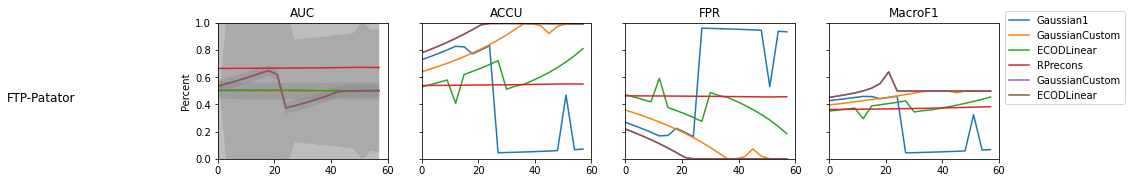

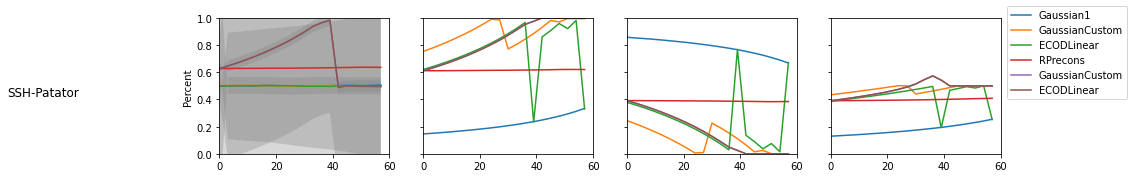

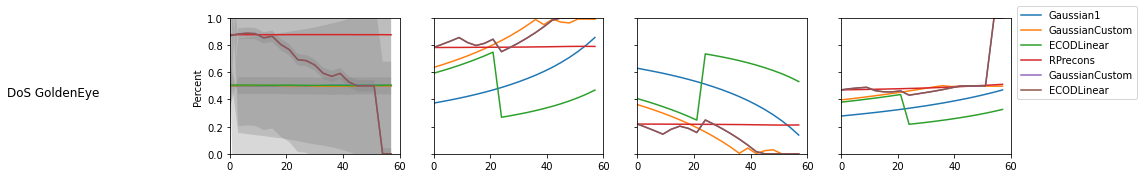

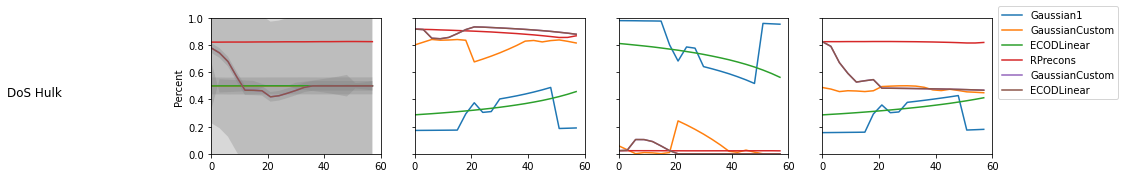

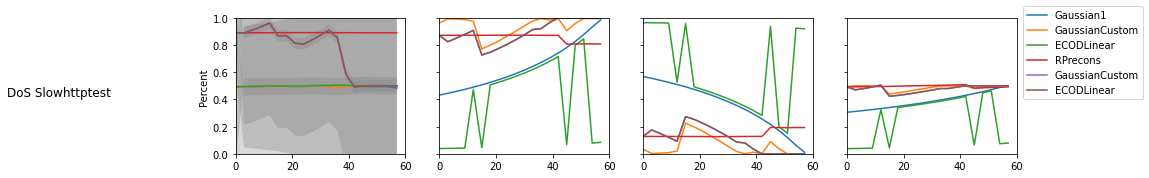

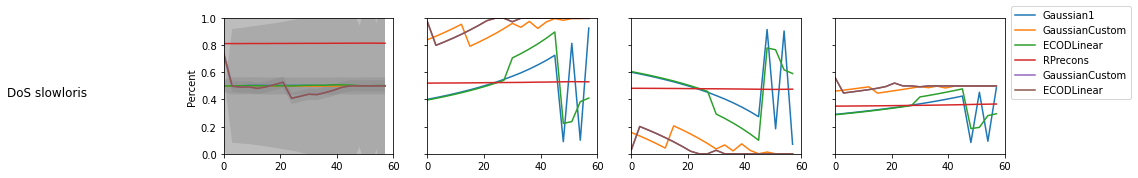

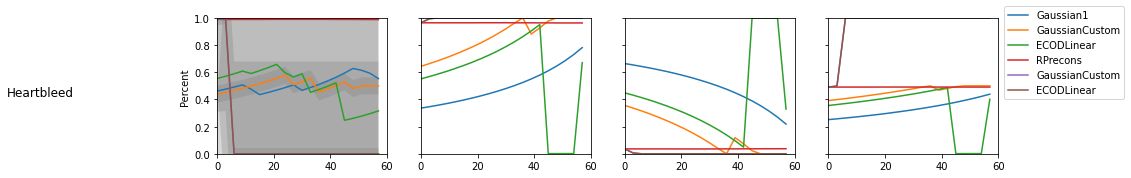

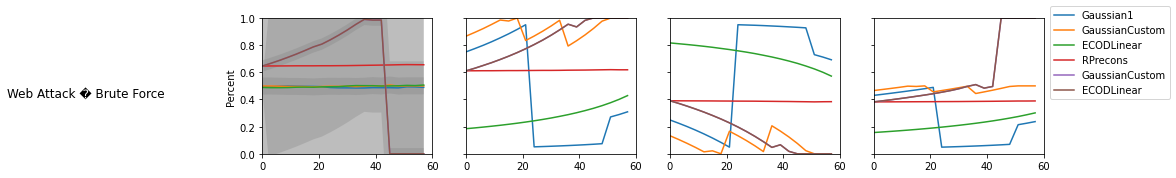

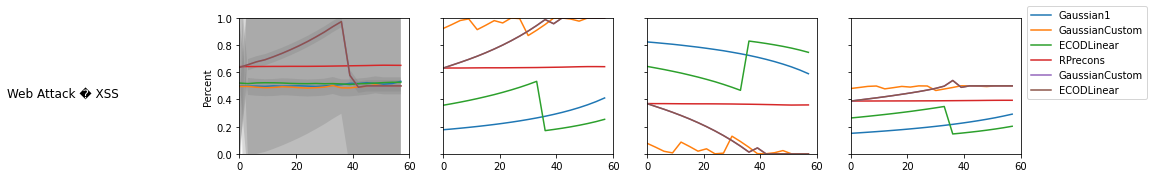

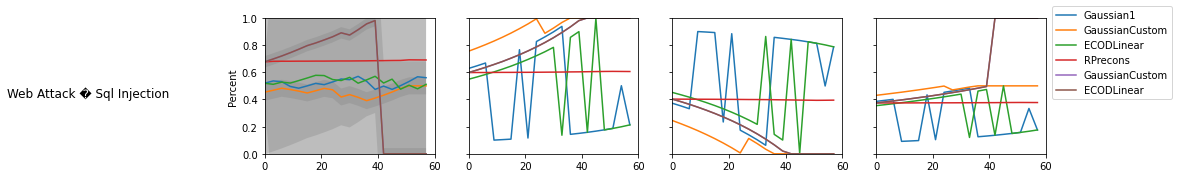

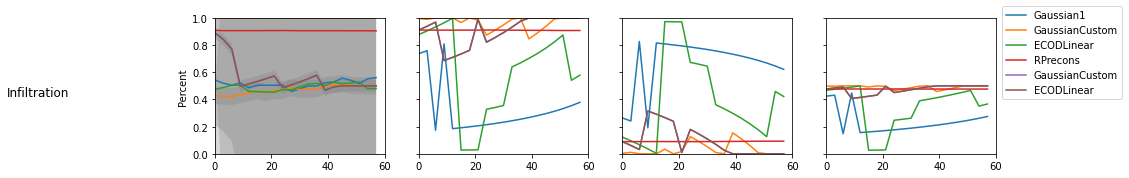

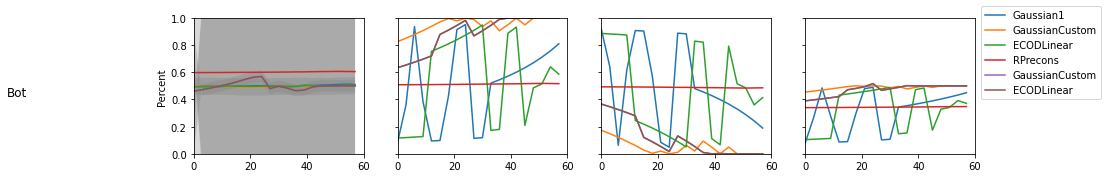

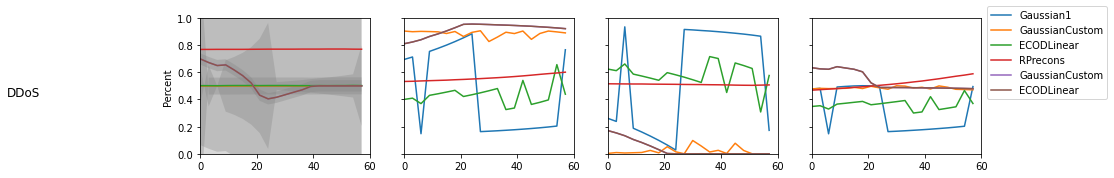

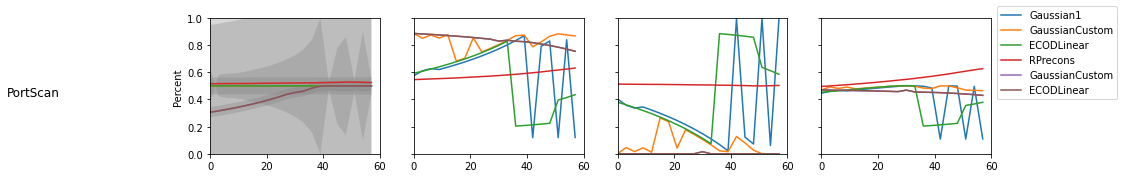

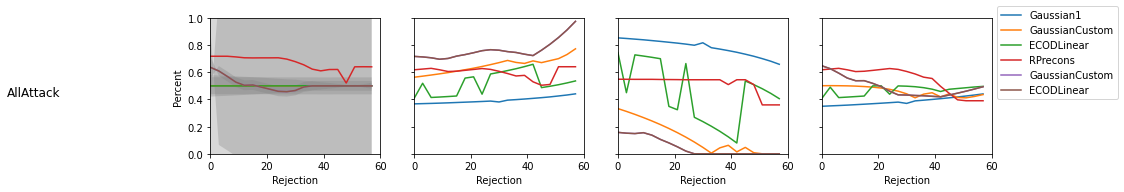

the AUC of this model is 0.6837758719921112


In [18]:
#pd_reader=pd.read_csv('../../venv/MyBayesian/pplots/BAE+allmetrics.csv' )  #,skiprows=251)

pd_reader=pd.read_csv('../../venv/MyBayesian/pplots/BDL'+savename+'+allmetrics.csv' )  #,skiprows=251)   
# plot comparision in different phase of each type
total_auc=0 # average of the largest AUC of each types
modelname='BDL'
tw_auc,tw_accu=0,0
model_dict={}
model_dict["metricname"]=pd_reader.iloc[17,1:11]
for each in range(1,len( attack_types)):
    fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1,4,figsize=(14,2.5),sharey=True) 
    fig.suptitle(attack_types[each] ,x=-0.05,y=0.5) # {typename} {modelname}')
    best_auc=0
    w_auc=0  #average
    w_accu=0  # average
    for i in range(0,len(pd_reader)):
        if '+' in pd_reader.iloc[i,0] :
            if pd_reader.iloc[i,0].split('+')[1]==attack_types[each]:
                legendd=pd_reader.iloc[i,0].split('+')[0]
                
                if legendd in model_dict.keys():
                    model_dict[legendd]=(model_dict[legendd]+pd_reader.iloc[i+17,1:11].astype(np.float16))/2.0
                else: 
                    model_dict[legendd]=pd_reader.iloc[i+17,1:11].astype(np.float16)     
                    
                #fig_title=pd_reader.iloc[i,0]
                xx=pd_reader.iloc[i+2,1:].astype(int)
                y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)

                plot_title=pd_reader.iloc[i+2,0]            
                y_values=pd_reader.iloc[i+3,1:].astype(np.float16)
                
                if best_auc<  np.max(y_values):
                    best_auc=np.max(y_values)
                if w_auc<float(pd_reader.iloc[i+17,2]):
                    w_auc=float( pd_reader.iloc[i+17,2])
                    # print(f'the better weight_auc {w_auc}is belongs: {attack_types[each]}{legendd}')
                if w_accu<float(pd_reader.iloc[i+17,3]):
                    w_accu=float(pd_reader.iloc[i+17,3])
                    #print(f'the better weight_accu {w_accu}is belongs: {attack_types[each]}{legendd}')
                '''    # for remove angles
                for ind in range(1,len(y_values)):
                    if np.abs((y_values[ind-1]-y_values[ind]))>0.6:
                        yyy=y_values[:,ind-1]                        
                        xxx=xx[:,ind-1]
                        '''
                # AUC
                ax1.plot(xx,y_values,label=legendd)                
                ax1.fill_between(xx,y_values-y_uncer,y_values+y_uncer,alpha=0.3,facecolor='grey')
                ax1.set(ylabel='Percent')              
                # ACCU
                ax2.plot(xx, pd_reader.iloc[i+9,1:].astype(np.float16) ) # , 'tab:green')                
                # FPR
                ax3.plot(xx, pd_reader.iloc[i+7,1:].astype(np.float16) ) #, 'tab:orange')          
                
                # Macro F1
                ax4.plot(xx, pd_reader.iloc[i+11,1:].astype(np.float16) ) # , 'tab:red')               
                
                if each==1:
                    ax1.set_title(plot_title)
                    ax2.set_title(pd_reader.iloc[i+8,0]) 
                    ax3.set_title(pd_reader.iloc[i+6,0])
                    ax4.set_title(pd_reader.iloc[i+10,0]) 
                if each==len(attack_types)-1:
                    ax1.set(xlabel='Rejection')
                    ax2.set(xlabel='Rejection')
                    ax3.set(xlabel='Rejection')
                    ax4.set(xlabel='Rejection')
                '''
                # F1
                ax6.plot(xx,pd_reader.iloc[i+13,1:].astype(np.float16) ) # , 'tab:purple')
                ax6.set_title(pd_reader.iloc[i+12,0])
                #ax6.set(xlabel='Rejection')
                 #GSS
                ax2.plot(xx,pd_reader.iloc[i+5,1:].astype(np.float16),label=legendd)  #
                ax2.set_title(pd_reader.iloc[i+4,0])
                #ax2.fill_between(xx,gsslist-unlist,gsslist+unlist,alpha=0.3,facecolor='grey')
                '''
                i=i+18  
   
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1.03,0.4))
           
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set_xlim(0,60)
        ax.set_ylim(0,1)
    total_auc=(total_auc+best_auc  ) /2
    tw_auc=(tw_auc+w_auc)/2
    tw_accu=(tw_accu+w_accu)/2
    '''
    nowtime=datetime.datetime.now()
    nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)    
    pyplot.savefig('plots/'+modelname+'+'+nowtime+'+'+"allmetrics.png")
    '''
    pyplot.show()
    
         
print(f'the AUC of this model is {total_auc}')
save_path = "pplots-RP/"+'allmetrics'+".csv"
#final_AUC={'total_AUC':total_auc, 'weight_AUC:':tw_auc,'weight_Accu:':tw_accu}
#save_data = pd.DataFrame.from_dict([final_AUC])
#save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

save_data=pd.DataFrame(model_dict)
save_data.to_csv(save_path, mode='a', header=True, index_label=modelname,index=True)

# plot models

In [ ]:
# plot comparision in different model of each type
fig, axes= pyplot.subplots(3, 5,figsize=(18,10),sharex=True,sharey=True) 
fig.suptitle('Comparisons of Models' ) 
diccsv='csvs-2/'
for indtype in range(1,len( attack_types)): 
    axes[(indtype-1)//5,(indtype-1)%5].set_title(attack_types[indtype] )
    
    for root,dirs,files in os.walk(diccsv):
        for each in files:
            if each.endswith('.csv') and each.split('-')[-1]!='checkpoint.csv' :  
                thislabel=each.split('+')[0]
                pd_reader=pd.read_csv(diccsv+each)
                init=0
                
                for i in range(init,len(pd_reader)): # show the first group results in csv
                    if '+' in pd_reader.iloc[i,0]:
                        if pd_reader.iloc[i,0].split('+')[1]==attack_types[indtype] and pd_reader.iloc[i,0].split('+')[0]=='GaussianCustom' : #'ECODLinear': # 
                           
                            xx=pd_reader.iloc[i+2,1:].astype(int)
                            y_uncer=pd_reader.iloc[i+15,1:].astype(np.float16)
                            #plot_title=pd_reader.iloc[i+2,0]            
                            #y_values=pd_reader.iloc[i+3,1:].astype(np.float16)  # AUC

                            #y_values=pd_reader.iloc[i+5,1:].astype(np.float16)  # GSS

                            y_values=pd_reader.iloc[i+9,1:].astype(np.float16)  # Accu
                            
                            axes[(indtype-1)//5,(indtype-1)%5].plot(xx,y_values,label=thislabel)
                            #ax1.fill_between(xx,y_values-y_uncer,y_values+y_uncer,alpha=0.3,facecolor='grey')
                            #ax1.set(ylabel='Percent')
                        
                            break
                            #i=i+18  
handles, labels = axes[0,2].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right" , bbox_to_anchor=(1,0.5))

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(0,60)
    ax.set_ylim(0,1)

nowtime=datetime.datetime.now()
nowtime=str(nowtime.year)+str(nowtime.month)+str(nowtime.day)+str(nowtime.hour)
pyplot.savefig('csvs/comparison+'+nowtime+'+'+"allmodels.png")
pyplot.show()

In [12]:
a='33+rr+wqw'
print (a.split('+')[2])

wqw


In [ ]:
# https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb#scrollTo=if4YhGgNzqnv&uniqifier=1
# prior function and posterior function is new in Tensorflow, no more explain on the return(make_normal_fn ). so discard ths.

kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


def normal_sp(params): 
    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable
 
inputs = Input(shape=(1,))

hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(learning_rate=0.0002), loss=NLL) 

model_params = Model(inputs=inputs, outputs=params)